# Single-cell RNA Sequencing of human scalp: Analysis

Data Source Acknowledgment: The dataset is sourced from [GSE212450](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE212450). This notebook uses sub-dataset which comprises single-cell RNA sequencing data from human scalp with alopecia areata (GSM6532922	AA8_scRNA) and control (GSM6532927	C_SD2_scRNA).

Reference: Ober-Reynolds B, Wang C, Ko JM, Rios EJ et al. Integrated single-cell chromatin and transcriptomic analyses of human scalp identify gene-regulatory programs and critical cell types for hair and skin diseases. Nat Genet 2023 Aug;55(8):1288-1300. PMID: 37500727

It's essential to emphasize that this dataset is exclusively utilized for Python practice purposes within this repository. This notebook will use this dataset to practice data cleaning techniques and clustering.

In [1]:
#using SCanalysis environment
import numpy as np
import pandas as pd
import seaborn as  sns
import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import anndata as ad

In [2]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", RuntimeWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)

In [3]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=160,
    facecolor="white",
    frameon=False,)

In [17]:
adata = sc.read_h5ad('annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 6699 × 33538
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'sample', 'celltypist_skin_label', 'celltypist_conf_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'celltypist_skin_major', 'manual_label'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_skin_label_colors', 'celltypist_skin_major_colors', 'log1p', 'manual_label_colors', 'neighbors', 'overcluster', 'overcluster_colors', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'log1p_norm'
    obsp: 'connectivities', 'distances'

## 1. Total proportion in each sample

Calculate the frequency of each cell types in case and control group

In [5]:
total_cells = adata.obs.groupby(['sample']).count()
total_cells

n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
sample                                                              
case                  4809                     4809          4809   
control               1890                     1890          1890   

         log1p_total_counts  pct_counts_in_top_20_genes  pct_counts_mt  \
sample                                                                   
case                   4809                        4809           4809   
control                1890                        1890           1890   

         pct_counts_ribo  pct_counts_hb  doublet  celltypist_skin_label  \
sample                                                                    
case                4809           4809     4809                   4809   
control             1890           1890     1890                   1890   

         celltypist_conf_score  _scvi_batch  _scvi_labels  overcluster  \
sample                                                                   
case                      4809         4809          4809         4809   
control                   1890         1890          1890         1890   

         celltypist_skin_major  manual_label  
sample                                        
case                      4809          4809  
control                   1890          1890

In [6]:
total_cells = dict(zip(total_cells.index, total_cells.doublet))

In [7]:
total_cells

{'case': 4809, 'control': 1890}

In [8]:
cell_type_count = adata.obs.groupby(['sample', 'manual_label']).count()

In [9]:
cell_type_count

n_genes_by_counts  log1p_n_genes_by_counts  \
sample  manual_label                                                        
case    CD4+T                               1821                     1821   
        CD8+T                                751                      751   
        HFDPC                                 52                       52   
        HF_keratinocyte                       12                       12   
        M1_macrophage                         29                       29   
        Treg                                 391                      391   
        basal_keratinocyte                   115                      115   
        dendritic_cell                       145                      145   
        dermal_fibroblast                    332                      332   
        dermal_sheath                        127                      127   
        lymphatic_endothelium                 40                       40   
        macrophage                           164                      164   
        mast_cell                             75                       75   
        melanocyte                            70                       70   
        myocyte                              261                      261   
        pericyte                              58                       58   
        plasma_cell                           54                       54   
        spinous_keratinocyte                 116                      116   
        vascular_endothelium                 196                      196   
control CD4+T                                108                      108   
        CD8+T                                 42                       42   
        HFDPC                                 54                       54   
        HF_keratinocyte                       73                       73   
        M1_macrophage                         12                       12   
        Treg                                  40                       40   
        basal_keratinocyte                    38                       38   
        dendritic_cell                        84                       84   
        dermal_fibroblast                    420                      420   
        dermal_sheath                         24                       24   
        lymphatic_endothelium                 16                       16   
        macrophage                           194                      194   
        mast_cell                            183                      183   
        melanocyte                            49                       49   
        myocyte                              106                      106   
        pericyte                              39                       39   
        plasma_cell                            3                        3   
        spinous_keratinocyte                 282                      282   
        vascular_endothelium                 123                      123   

                               total_counts  log1p_total_counts  \
sample  manual_label                                              
case    CD4+T                          1821                1821   
        CD8+T                           751                 751   
        HFDPC                            52                  52   
        HF_keratinocyte                  12                  12   
        M1_macrophage                    29                  29   
        Treg                            391                 391   
        basal_keratinocyte              115                 115   
        dendritic_cell                  145                 145   
        dermal_fibroblast               332                 332   
        dermal_sheath                   127                 127   
        lymphatic_endothelium            40                  40   
        macrophage                      164                 164   
        mast

In [10]:
#get rid of row with 0 and break these 2 index down into only 1 index
cell_type_count = cell_type_count[cell_type_count.sum(axis = 1) > 0].reset_index()
cell_type_count

sample           manual_label  n_genes_by_counts  \
0      case                  CD4+T               1821   
1      case                  CD8+T                751   
2      case                  HFDPC                 52   
3      case        HF_keratinocyte                 12   
4      case          M1_macrophage                 29   
5      case                   Treg                391   
6      case     basal_keratinocyte                115   
7      case         dendritic_cell                145   
8      case      dermal_fibroblast                332   
9      case          dermal_sheath                127   
10     case  lymphatic_endothelium                 40   
11     case             macrophage                164   
12     case              mast_cell                 75   
13     case             melanocyte                 70   
14     case                myocyte                261   
15     case               pericyte                 58   
16     case            plasma_cell                 54   
17     case   spinous_keratinocyte                116   
18     case   vascular_endothelium                196   
19  control                  CD4+T                108   
20  control                  CD8+T                 42   
21  control                  HFDPC                 54   
22  control        HF_keratinocyte                 73   
23  control          M1_macrophage                 12   
24  control                   Treg                 40   
25  control     basal_keratinocyte                 38   
26  control         dendritic_cell                 84   
27  control      dermal_fibroblast                420   
28  control          dermal_sheath                 24   
29  control  lymphatic_endothelium                 16   
30  control             macrophage                194   
31  control              mast_cell                183   
32  control             melanocyte                 49   
33  control                myocyte                106   
34  control               pericyte                 39   
35  control            plasma_cell                  3   
36  control   spinous_keratinocyte                282   
37  control   vascular_endothelium                123   

    log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
0                      1821          1821                1821   
1                       751           751                 751   
2                        52            52                  52   
3                        12            12                  12   
4                        29            29                  29   
5                       391           391                 391   
6                       115           115                 115   
7                       145           145                 145   
8                       332           332                 332   
9                       127           127                 127   
10                       40            40                  40   
11                      164           164                 164   
12                       75            75                  75   
13                       70            70                  70   
14                      261           261                 261   
15                       58            58                  58   
16                       54            54                  54   
17                      116           116                 116   
18                      196           196                 196   
19                      108           108                 108   
20                       42            42                  42   
21                       54            54                  54   
22                       73            73                  73   
23                       12            12                  12   
24                       40            40                  40   
25                       38            38                  38   
26                       8

In [11]:
cell_type_count = cell_type_count[['sample', 'manual_label', 'doublet']]
cell_type_count

sample           manual_label  doublet
0      case                  CD4+T     1821
1      case                  CD8+T      751
2      case                  HFDPC       52
3      case        HF_keratinocyte       12
4      case          M1_macrophage       29
5      case                   Treg      391
6      case     basal_keratinocyte      115
7      case         dendritic_cell      145
8      case      dermal_fibroblast      332
9      case          dermal_sheath      127
10     case  lymphatic_endothelium       40
11     case             macrophage      164
12     case              mast_cell       75
13     case             melanocyte       70
14     case                myocyte      261
15     case               pericyte       58
16     case            plasma_cell       54
17     case   spinous_keratinocyte      116
18     case   vascular_endothelium      196
19  control                  CD4+T      108
20  control                  CD8+T       42
21  control                  HFDPC       54
22  control        HF_keratinocyte       73
23  control          M1_macrophage       12
24  control                   Treg       40
25  control     basal_keratinocyte       38
26  control         dendritic_cell       84
27  control      dermal_fibroblast      420
28  control          dermal_sheath       24
29  control  lymphatic_endothelium       16
30  control             macrophage      194
31  control              mast_cell      183
32  control             melanocyte       49
33  control                myocyte      106
34  control               pericyte       39
35  control            plasma_cell        3
36  control   spinous_keratinocyte      282
37  control   vascular_endothelium      123

In [12]:
#add total cell of each sample in the new column
cell_type_count['total_cells'] = cell_type_count['sample'].map(total_cells)
cell_type_count

/var/folders/ly/mwzzbn7j7yd69hdl9hq_23540000gn/T/ipykernel_3905/781081177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_type_count['total_cells'] = cell_type_count['sample'].map(total_cells)


sample           manual_label  doublet total_cells
0      case                  CD4+T     1821        4809
1      case                  CD8+T      751        4809
2      case                  HFDPC       52        4809
3      case        HF_keratinocyte       12        4809
4      case          M1_macrophage       29        4809
5      case                   Treg      391        4809
6      case     basal_keratinocyte      115        4809
7      case         dendritic_cell      145        4809
8      case      dermal_fibroblast      332        4809
9      case          dermal_sheath      127        4809
10     case  lymphatic_endothelium       40        4809
11     case             macrophage      164        4809
12     case              mast_cell       75        4809
13     case             melanocyte       70        4809
14     case                myocyte      261        4809
15     case               pericyte       58        4809
16     case            plasma_cell       54        4809
17     case   spinous_keratinocyte      116        4809
18     case   vascular_endothelium      196        4809
19  control                  CD4+T      108        1890
20  control                  CD8+T       42        1890
21  control                  HFDPC       54        1890
22  control        HF_keratinocyte       73        1890
23  control          M1_macrophage       12        1890
24  control                   Treg       40        1890
25  control     basal_keratinocyte       38        1890
26  control         dendritic_cell       84        1890
27  control      dermal_fibroblast      420        1890
28  control          dermal_sheath       24        1890
29  control  lymphatic_endothelium       16        1890
30  control             macrophage      194        1890
31  control              mast_cell      183        1890
32  control             melanocyte       49        1890
33  control                myocyte      106        1890
34  control               pericyte       39        1890
35  control            plasma_cell        3        1890
36  control   spinous_keratinocyte      282        1890
37  control   vascular_endothelium      123        1890

In [13]:
cell_type_count.dtypes

sample          category
manual_label    category
doublet            int64
total_cells     category
dtype: object

In [14]:
cell_type_count['total_cells'] = cell_type_count['total_cells'].astype(int)
cell_type_count['frequency'] = cell_type_count.doublet / cell_type_count.total_cells
cell_type_count

/var/folders/ly/mwzzbn7j7yd69hdl9hq_23540000gn/T/ipykernel_3905/4273496426.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_type_count['total_cells'] = cell_type_count['total_cells'].astype(int)
/var/folders/ly/mwzzbn7j7yd69hdl9hq_23540000gn/T/ipykernel_3905/4273496426.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_type_count['frequency'] = cell_type_count.doublet / cell_type_count.total_cells


sample           manual_label  doublet  total_cells  frequency
0      case                  CD4+T     1821         4809   0.378665
1      case                  CD8+T      751         4809   0.156166
2      case                  HFDPC       52         4809   0.010813
3      case        HF_keratinocyte       12         4809   0.002495
4      case          M1_macrophage       29         4809   0.006030
5      case                   Treg      391         4809   0.081306
6      case     basal_keratinocyte      115         4809   0.023913
7      case         dendritic_cell      145         4809   0.030152
8      case      dermal_fibroblast      332         4809   0.069037
9      case          dermal_sheath      127         4809   0.026409
10     case  lymphatic_endothelium       40         4809   0.008318
11     case             macrophage      164         4809   0.034103
12     case              mast_cell       75         4809   0.015596
13     case             melanocyte       70         4809   0.014556
14     case                myocyte      261         4809   0.054273
15     case               pericyte       58         4809   0.012061
16     case            plasma_cell       54         4809   0.011229
17     case   spinous_keratinocyte      116         4809   0.024121
18     case   vascular_endothelium      196         4809   0.040757
19  control                  CD4+T      108         1890   0.057143
20  control                  CD8+T       42         1890   0.022222
21  control                  HFDPC       54         1890   0.028571
22  control        HF_keratinocyte       73         1890   0.038624
23  control          M1_macrophage       12         1890   0.006349
24  control                   Treg       40         1890   0.021164
25  control     basal_keratinocyte       38         1890   0.020106
26  control         dendritic_cell       84         1890   0.044444
27  control      dermal_fibroblast      420         1890   0.222222
28  control          dermal_sheath       24         1890   0.012698
29  control  lymphatic_endothelium       16         1890   0.008466
30  control             macrophage      194         1890   0.102646
31  control              mast_cell      183         1890   0.096825
32  control             melanocyte       49         1890   0.025926
33  control                myocyte      106         1890   0.056085
34  control               pericyte       39         1890   0.020635
35  control            plasma_cell        3         1890   0.001587
36  control   spinous_keratinocyte      282         1890   0.149206
37  control   vascular_endothelium      123         1890   0.065079

In [15]:
#create stack bar plot of each samples

cell_types = cell_type_count['manual_label'].unique() #get unique cell type
df_grouped = cell_type_count.groupby(['sample', 'manual_label'])['frequency'].sum().unstack()
df_grouped = df_grouped.reset_index()
df_grouped

manual_label   sample     CD4+T     CD8+T     HFDPC  HF_keratinocyte  \
0                case  0.378665  0.156166  0.010813         0.002495   
1             control  0.057143  0.022222  0.028571         0.038624   

manual_label  M1_macrophage      Treg  basal_keratinocyte  dendritic_cell  \
0                  0.006030  0.081306            0.023913        0.030152   
1                  0.006349  0.021164            0.020106        0.044444   

manual_label  dermal_fibroblast  dermal_sheath  lymphatic_endothelium  \
0                      0.069037       0.026409               0.008318   
1                      0.222222       0.012698               0.008466   

manual_label  macrophage  mast_cell  melanocyte   myocyte  pericyte  \
0               0.034103   0.015596    0.014556  0.054273  0.012061   
1               0.102646   0.096825    0.025926  0.056085  0.020635   

manual_label  plasma_cell  spinous_keratinocyte  vascular_endothelium  
0                0.011229              0.024121              0.040757  
1                0.001587              0.149206              0.065079

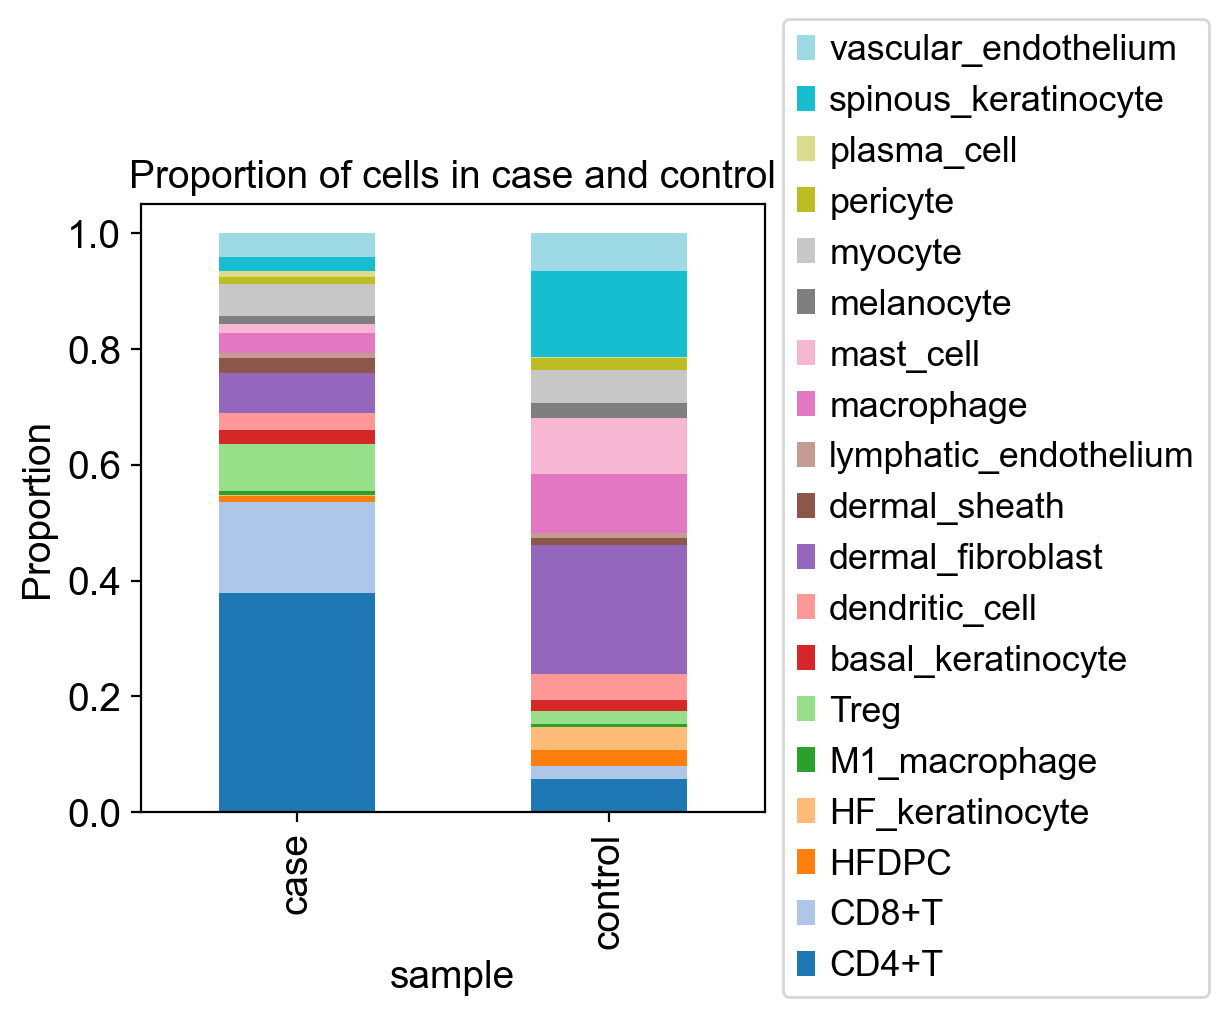

In [16]:
ax = df_grouped.plot(x='sample', kind='bar', stacked=True, colormap='tab20')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
plt.ylabel('Proportion')
plt.title('Proportion of cells in case and control')
# Remove grid lines
ax.grid(False)
plt.show()

In [17]:
cell_type_count_eachType = adata.obs.groupby(['manual_label']).count()

In [18]:
cell_type_count_eachType

n_genes_by_counts  log1p_n_genes_by_counts  \
manual_label                                                        
CD4+T                               1929                     1929   
CD8+T                                793                      793   
HFDPC                                106                      106   
HF_keratinocyte                       85                       85   
M1_macrophage                         41                       41   
Treg                                 431                      431   
basal_keratinocyte                   153                      153   
dendritic_cell                       229                      229   
dermal_fibroblast                    752                      752   
dermal_sheath                        151                      151   
lymphatic_endothelium                 56                       56   
macrophage                           358                      358   
mast_cell                            258                      258   
melanocyte                           119                      119   
myocyte                              367                      367   
pericyte                              97                       97   
plasma_cell                           57                       57   
spinous_keratinocyte                 398                      398   
vascular_endothelium                 319                      319   

                       total_counts  log1p_total_counts  \
manual_label                                              
CD4+T                          1929                1929   
CD8+T                           793                 793   
HFDPC                           106                 106   
HF_keratinocyte                  85                  85   
M1_macrophage                    41                  41   
Treg                            431                 431   
basal_keratinocyte              153                 153   
dendritic_cell                  229                 229   
dermal_fibroblast               752                 752   
dermal_sheath                   151                 151   
lymphatic_endothelium            56                  56   
macrophage                      358                 358   
mast_cell                       258                 258   
melanocyte                      119                 119   
myocyte                         367                 367   
pericyte                         97                  97   
plasma_cell                      57                  57   
spinous_keratinocyte            398                 398   
vascular_endothelium            319                 319   

                       pct_counts_in_top_20_genes  pct_counts_mt  \
manual_label                                                       
CD4+T                                        1929           1929   
CD8+T                                         793            793   
HFDPC                                         106            106   
HF_keratinocyte                                85             85   
M1_macrophage                                  41             41   
Treg                                          431            431   
basal_keratinocyte                            153            153   
dendritic_cell                                229            229   
dermal_fibroblast                             752            752   
dermal_sheath                                 151            151   
lymphatic_endothelium                          56             56   
macrophage                                    358            358   
mast_cell                                     258            258   
melanocyte                                    119            119   
myocyte                                       367            367   
pericyte                                       97             97   
plasma_cell                                    57             57   
spinous_keratinocyte                     

In [19]:
total_cell_eachType = dict(zip(cell_type_count_eachType.index, cell_type_count_eachType.doublet))

In [20]:
total_cell_eachType 

{'CD4+T': 1929,
 'CD8+T': 793,
 'HFDPC': 106,
 'HF_keratinocyte': 85,
 'M1_macrophage': 41,
 'Treg': 431,
 'basal_keratinocyte': 153,
 'dendritic_cell': 229,
 'dermal_fibroblast': 752,
 'dermal_sheath': 151,
 'lymphatic_endothelium': 56,
 'macrophage': 358,
 'mast_cell': 258,
 'melanocyte': 119,
 'myocyte': 367,
 'pericyte': 97,
 'plasma_cell': 57,
 'spinous_keratinocyte': 398,
 'vascular_endothelium': 319}

In [21]:
cell_type_count['total_cells_eachType'] = cell_type_count['manual_label'].map(total_cell_eachType)

/var/folders/ly/mwzzbn7j7yd69hdl9hq_23540000gn/T/ipykernel_3905/3510994949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_type_count['total_cells_eachType'] = cell_type_count['manual_label'].map(total_cell_eachType)


In [22]:
cell_type_count

sample           manual_label  doublet  total_cells  frequency  \
0      case                  CD4+T     1821         4809   0.378665   
1      case                  CD8+T      751         4809   0.156166   
2      case                  HFDPC       52         4809   0.010813   
3      case        HF_keratinocyte       12         4809   0.002495   
4      case          M1_macrophage       29         4809   0.006030   
5      case                   Treg      391         4809   0.081306   
6      case     basal_keratinocyte      115         4809   0.023913   
7      case         dendritic_cell      145         4809   0.030152   
8      case      dermal_fibroblast      332         4809   0.069037   
9      case          dermal_sheath      127         4809   0.026409   
10     case  lymphatic_endothelium       40         4809   0.008318   
11     case             macrophage      164         4809   0.034103   
12     case              mast_cell       75         4809   0.015596   
13     case             melanocyte       70         4809   0.014556   
14     case                myocyte      261         4809   0.054273   
15     case               pericyte       58         4809   0.012061   
16     case            plasma_cell       54         4809   0.011229   
17     case   spinous_keratinocyte      116         4809   0.024121   
18     case   vascular_endothelium      196         4809   0.040757   
19  control                  CD4+T      108         1890   0.057143   
20  control                  CD8+T       42         1890   0.022222   
21  control                  HFDPC       54         1890   0.028571   
22  control        HF_keratinocyte       73         1890   0.038624   
23  control          M1_macrophage       12         1890   0.006349   
24  control                   Treg       40         1890   0.021164   
25  control     basal_keratinocyte       38         1890   0.020106   
26  control         dendritic_cell       84         1890   0.044444   
27  control      dermal_fibroblast      420         1890   0.222222   
28  control          dermal_sheath       24         1890   0.012698   
29  control  lymphatic_endothelium       16         1890   0.008466   
30  control             macrophage      194         1890   0.102646   
31  control              mast_cell      183         1890   0.096825   
32  control             melanocyte       49         1890   0.025926   
33  control                myocyte      106         1890   0.056085   
34  control               pericyte       39         1890   0.020635   
35  control            plasma_cell        3         1890   0.001587   
36  control   spinous_keratinocyte      282         1890   0.149206   
37  control   vascular_endothelium      123         1890   0.065079   

   total_cells_eachType  
0                  1929  
1                   793  
2                   106  
3                    85  
4                    41  
5                   431  
6                   153  
7                   229  
8                   752  
9                   151  
10                   56  
11                  358  
12                  258  
13                  119  
14                  367  
15                   97  
16                   57  
17                  398  
18                  319  
19                 1929  
20                  793  
21                  106  
22                   85  
23                   41  
24                  431  
25                  153  
26                  229  
27                  752  
28                  151  
29                   56  
30                  358  
31                  258  
32                  119  
33                  367  
34                   97  
35                   57  
36                  398  
37                  319

In [23]:
cell_type_count.dtypes

sample                  category
manual_label            category
doublet                    int64
total_cells                int64
frequency                float64
total_cells_eachType    category
dtype: object

In [24]:
cell_type_count['total_cells_eachType'] = cell_type_count['total_cells_eachType'].astype(int)
cell_type_count['frequency_eachType'] = cell_type_count.doublet / cell_type_count.total_cells_eachType
cell_type_count

/var/folders/ly/mwzzbn7j7yd69hdl9hq_23540000gn/T/ipykernel_3905/890378272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_type_count['total_cells_eachType'] = cell_type_count['total_cells_eachType'].astype(int)
/var/folders/ly/mwzzbn7j7yd69hdl9hq_23540000gn/T/ipykernel_3905/890378272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_type_count['frequency_eachType'] = cell_type_count.doublet / cell_type_count.total_cells_eachType


sample           manual_label  doublet  total_cells  frequency  \
0      case                  CD4+T     1821         4809   0.378665   
1      case                  CD8+T      751         4809   0.156166   
2      case                  HFDPC       52         4809   0.010813   
3      case        HF_keratinocyte       12         4809   0.002495   
4      case          M1_macrophage       29         4809   0.006030   
5      case                   Treg      391         4809   0.081306   
6      case     basal_keratinocyte      115         4809   0.023913   
7      case         dendritic_cell      145         4809   0.030152   
8      case      dermal_fibroblast      332         4809   0.069037   
9      case          dermal_sheath      127         4809   0.026409   
10     case  lymphatic_endothelium       40         4809   0.008318   
11     case             macrophage      164         4809   0.034103   
12     case              mast_cell       75         4809   0.015596   
13     case             melanocyte       70         4809   0.014556   
14     case                myocyte      261         4809   0.054273   
15     case               pericyte       58         4809   0.012061   
16     case            plasma_cell       54         4809   0.011229   
17     case   spinous_keratinocyte      116         4809   0.024121   
18     case   vascular_endothelium      196         4809   0.040757   
19  control                  CD4+T      108         1890   0.057143   
20  control                  CD8+T       42         1890   0.022222   
21  control                  HFDPC       54         1890   0.028571   
22  control        HF_keratinocyte       73         1890   0.038624   
23  control          M1_macrophage       12         1890   0.006349   
24  control                   Treg       40         1890   0.021164   
25  control     basal_keratinocyte       38         1890   0.020106   
26  control         dendritic_cell       84         1890   0.044444   
27  control      dermal_fibroblast      420         1890   0.222222   
28  control          dermal_sheath       24         1890   0.012698   
29  control  lymphatic_endothelium       16         1890   0.008466   
30  control             macrophage      194         1890   0.102646   
31  control              mast_cell      183         1890   0.096825   
32  control             melanocyte       49         1890   0.025926   
33  control                myocyte      106         1890   0.056085   
34  control               pericyte       39         1890   0.020635   
35  control            plasma_cell        3         1890   0.001587   
36  control   spinous_keratinocyte      282         1890   0.149206   
37  control   vascular_endothelium      123         1890   0.065079   

    total_cells_eachType  frequency_eachType  
0                   1929            0.944012  
1                    793            0.947037  
2                    106            0.490566  
3                     85            0.141176  
4                     41            0.707317  
5                    431            0.907193  
6                    153            0.751634  
7                    229            0.633188  
8                    752            0.441489  
9                    151            0.841060  
10                    56            0.714286  
11                   358            0.458101  
12                   258            0.290698  
13                   119            0.588235  
14                   367            0.711172  
15                    97            0.597938  
16                    57            0.947368  
17                   398            0.291457  
18                   319            0.614420  
19                  1929            0.055988  
20                   793            0.052963  
21                   106            0.509434  
22                    85            0.858824  
23                    41            0.292683  
24                   431            0.092807  
25           

In [25]:
#create stack bar plot of each samples
cell_types = cell_type_count['manual_label'].unique()
df_grouped = cell_type_count.groupby(['sample', 'manual_label'])['frequency_eachType'].sum().unstack()
df_grouped = df_grouped.T
df_grouped

sample                     case   control
manual_label                             
CD4+T                  0.944012  0.055988
CD8+T                  0.947037  0.052963
HFDPC                  0.490566  0.509434
HF_keratinocyte        0.141176  0.858824
M1_macrophage          0.707317  0.292683
Treg                   0.907193  0.092807
basal_keratinocyte     0.751634  0.248366
dendritic_cell         0.633188  0.366812
dermal_fibroblast      0.441489  0.558511
dermal_sheath          0.841060  0.158940
lymphatic_endothelium  0.714286  0.285714
macrophage             0.458101  0.541899
mast_cell              0.290698  0.709302
melanocyte             0.588235  0.411765
myocyte                0.711172  0.288828
pericyte               0.597938  0.402062
plasma_cell            0.947368  0.052632
spinous_keratinocyte   0.291457  0.708543
vascular_endothelium   0.614420  0.385580

In [26]:
df_grouped = df_grouped.reset_index()

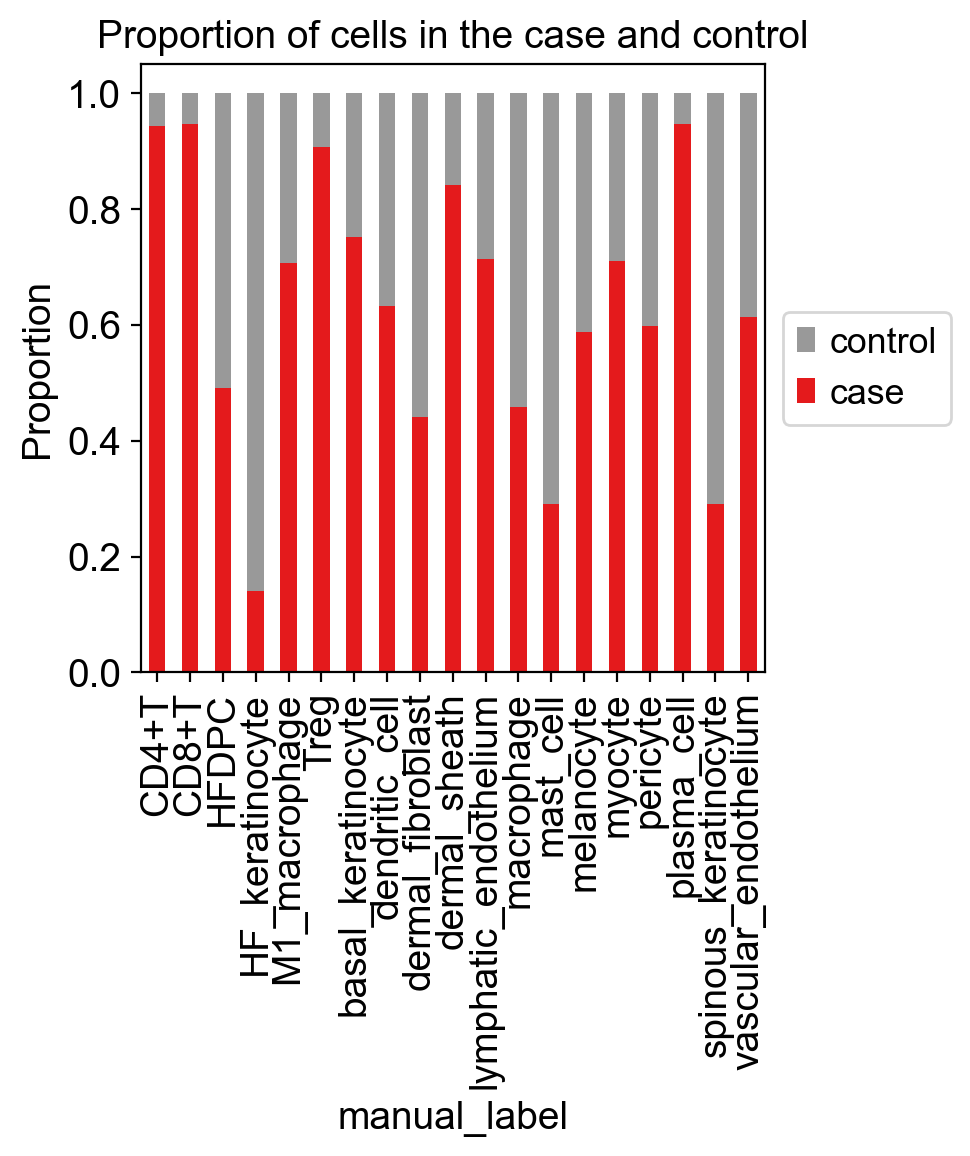

In [27]:
ax = df_grouped.plot(x= 'manual_label', kind='bar', stacked=True, colormap='Set1')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
plt.ylabel('Proportion')
plt.title('Proportion of cells in the case and control')
# Remove grid lines
ax.grid(False)
plt.show()

# 2. Compositional data analysis 

performing without pertpy

In [6]:
import sccoda
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

In [9]:
adata_case = adata[adata.obs['sample'] == 'case']

In [10]:
adata_control = adata[adata.obs['sample'] == 'control']

In [80]:
cov_df = pd.DataFrame({"hair": ["bold", "normal"]}, index=[1,2])

In [81]:
#data preparation
sccoda_data = dat.from_scanpy_list(
    [adata_case , adata_control],
    cell_type_identifier="manual_label",
    covariate_df = cov_df)
print(sccoda_data)

AnnData object with n_obs × n_vars = 2 × 19
    obs: 'hair'
    var: 'n_cells'


In [82]:
sccoda_data.obs

hair
1    bold
2  normal

In [83]:
sccoda_data.var_names

Index(['CD4+T', 'CD8+T', 'Treg', 'dermal_fibroblast', 'myocyte',
       'vascular_endothelium', 'macrophage', 'dendritic_cell', 'dermal_sheath',
       'spinous_keratinocyte', 'basal_keratinocyte', 'mast_cell', 'melanocyte',
       'pericyte', 'plasma_cell', 'HFDPC', 'lymphatic_endothelium',
       'M1_macrophage', 'HF_keratinocyte'],
      dtype='object', name='manual_label')

In [84]:
sccoda_data.X

array([[1821,  751,  391,  332,  261,  196,  164,  145,  127,  116,  115,
          75,   70,   58,   54,   52,   40,   29,   12],
       [ 108,   42,   40,  420,  106,  123,  194,   84,   24,  282,   38,
         183,   49,   39,    3,   54,   16,   12,   73]])

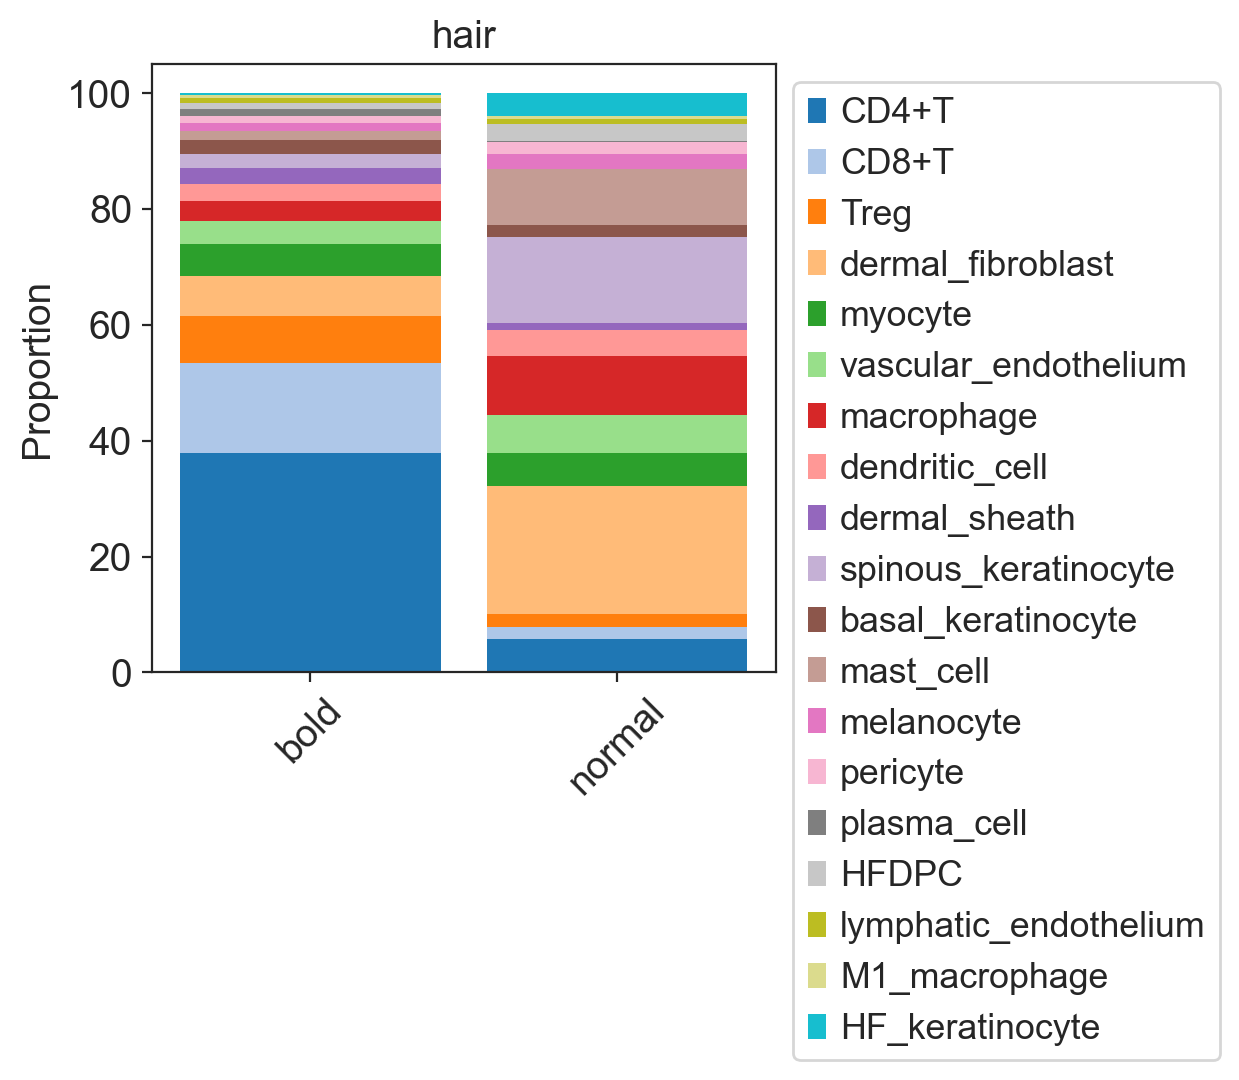

In [85]:
viz.stacked_barplot(sccoda_data, feature_name= "hair")
plt.show()

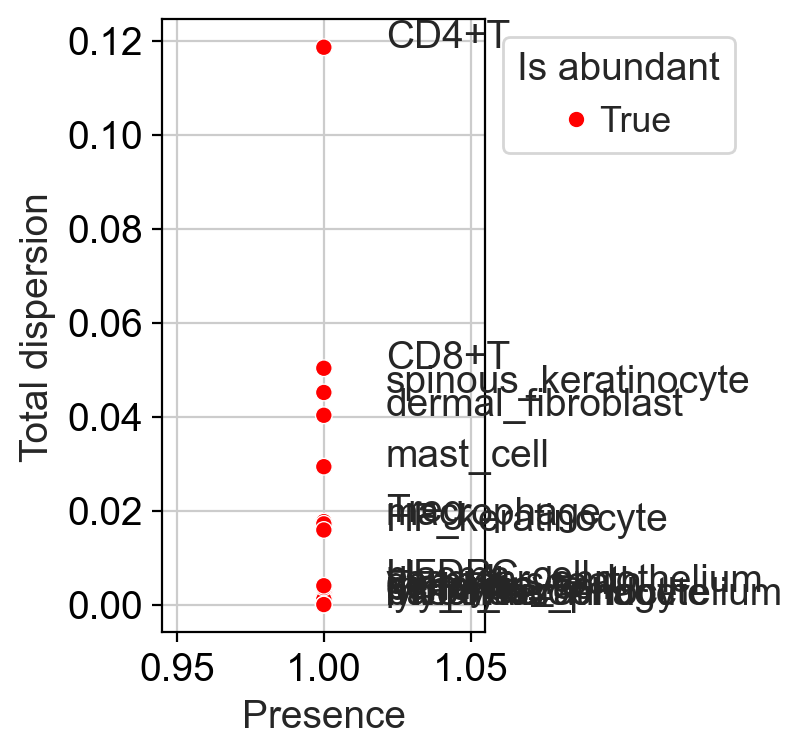

In [99]:
#Finding a reference cell type
#Cell types that have a higher presence than a certain threshold (default 0.9) are suitable candidates for the reference and thus colored.
viz.rel_abundance_dispersion_plot(
    data=sccoda_data,
    abundant_threshold=0.9
)
plt.show()

In [100]:
model = mod.CompositionalAnalysis(sccoda_data, formula="hair", reference_cell_type="automatic")

Automatic reference selection! Reference cell type set to lymphatic_endothelium


In [101]:
# Run MCMC
sim_results = model.sample_hmc()

I0000 00:00:1723112660.577482  132131 service.cc:145] XLA service 0x6000023a0d00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723112660.579084  132131 service.cc:153]   StreamExecutor device (0): Host, Default Version
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:15<00:00, 264.42it/s]


MCMC sampling finished. (99.023 sec)
Acceptance rate: 53.8%


In [102]:
sim_results.summary()

Compositional Analysis summary:

Data: 2 samples, 19 cell types
Reference index: 16
Formula: hair

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
CD4+T                            4.449      1285.549002
CD8+T                            3.522       508.742068
Treg                             2.798       246.642802
dermal_fibroblast                2.823       252.886594
myocyte                          2.390       164.012254
vascular_endothelium             2.255       143.300116
macrophage                       2.165       130.966445
dendritic_cell                   1.880        98.488633
dermal_sheath                    1.469        65.296677
spinous_keratinocyte             1.832        93.872844
basal_keratinocyte               1.488        66.549175
mast_cell                        1.467        65.166214
melanocyte                       1.256        52.769910
pericyte                         1.037        42.

In [103]:
print(sim_results.credible_effects())

Covariate       Cell Type            
hair[T.normal]  CD4+T                     True
                CD8+T                     True
                Treg                      True
                dermal_fibroblast        False
                myocyte                  False
                vascular_endothelium     False
                macrophage               False
                dendritic_cell           False
                dermal_sheath            False
                spinous_keratinocyte      True
                basal_keratinocyte       False
                mast_cell                False
                melanocyte               False
                pericyte                 False
                plasma_cell              False
                HFDPC                    False
                lymphatic_endothelium    False
                M1_macrophage            False
                HF_keratinocyte          False
Name: Final Parameter, dtype: bool


performing with pertpy and save the result in MuData

In [8]:
import pertpy as pt
import mudata as mu

In [12]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="manual_label",
    sample_identifier="sample",
    covariate_obs=["sample"],
)
sccoda_data

MuData object with n_obs × n_vars = 6701 × 33557
  2 modalities
    rna:	6699 x 33538
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'sample', 'celltypist_skin_label', 'celltypist_conf_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'celltypist_skin_major', 'manual_label', 'scCODA_sample_id'
      uns:	'_scvi_manager_uuid', '_scvi_uuid', 'celltypist_skin_label_colors', 'celltypist_skin_major_colors', 'log1p', 'manual_label_colors', 'neighbors', 'overcluster', 'overcluster_colors', 'rank_genes_groups', 'sample_colors', 'umap'
      obsm:	'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
      layers:	'counts', 'log1p_norm'
      obsp:	'connectivities', 'distances'
    coda:	2 x 19
      obs:	'sample'
      var:	'n_cells'

In [14]:
sccoda_data.mod['coda'].obs

sample
scCODA_sample_id         
case                 case
control           control

In [15]:
sccoda_data.mod['coda'].var_names

Index(['CD4+T', 'CD8+T', 'HFDPC', 'HF_keratinocyte', 'M1_macrophage', 'Treg',
       'basal_keratinocyte', 'dendritic_cell', 'dermal_fibroblast',
       'dermal_sheath', 'lymphatic_endothelium', 'macrophage', 'mast_cell',
       'melanocyte', 'myocyte', 'pericyte', 'plasma_cell',
       'spinous_keratinocyte', 'vascular_endothelium'],
      dtype='object', name='manual_label')

In [16]:
sccoda_data.mod['coda'].X

array([[1821,  751,   52,   12,   29,  391,  115,  145,  332,  127,   40,
         164,   75,   70,  261,   58,   54,  116,  196],
       [ 108,   42,   54,   73,   12,   40,   38,   84,  420,   24,   16,
         194,  183,   49,  106,   39,    3,  282,  123]])

<Axes: title={'center': 'sample'}, ylabel='Proportion'>

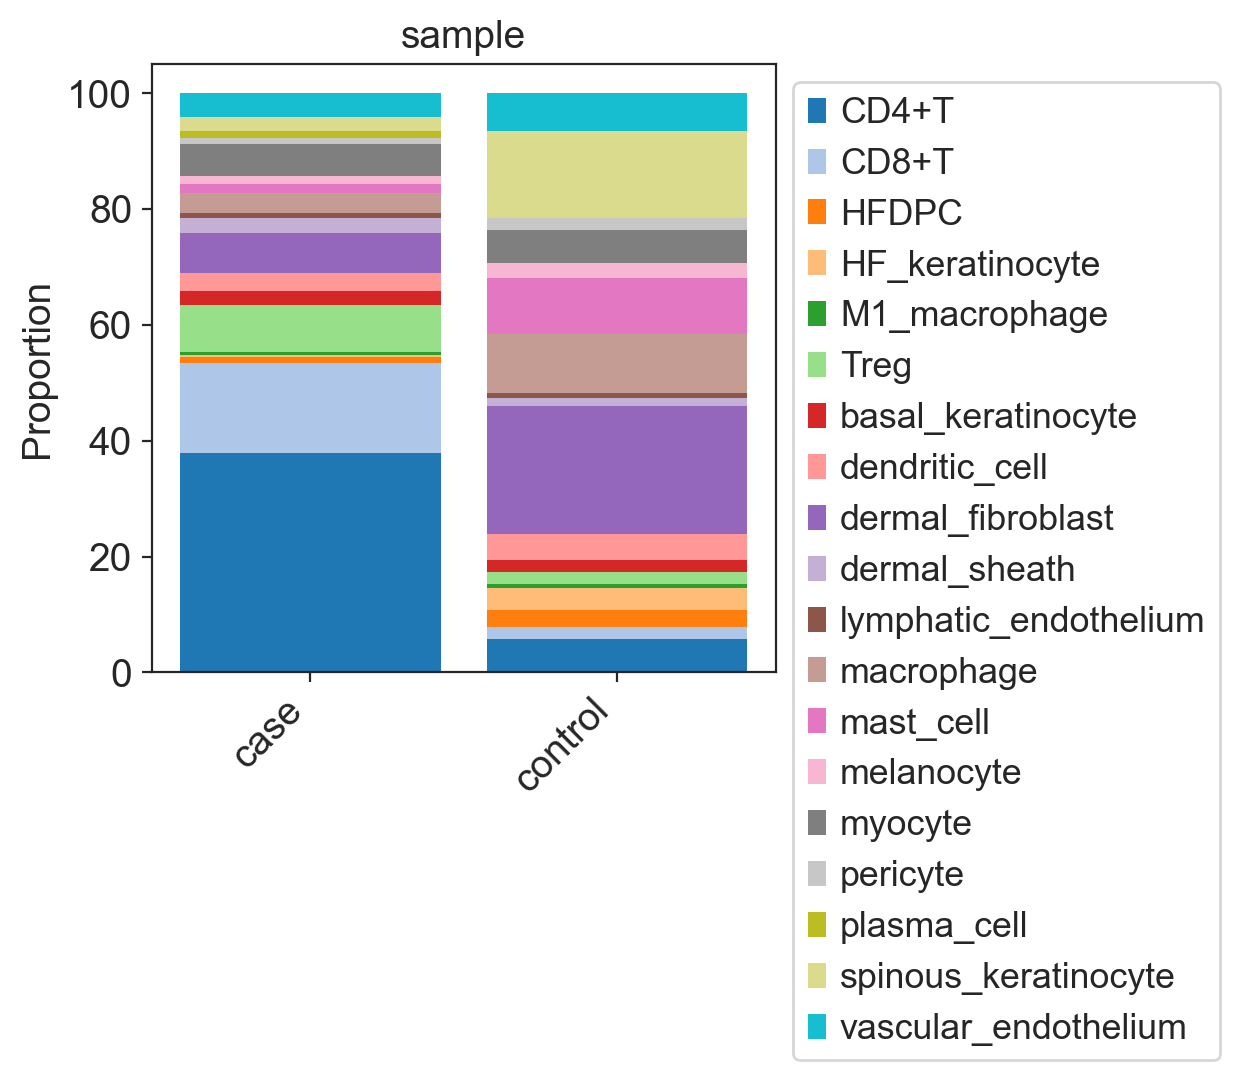

In [21]:
sccoda_model.plot_stacked_barplot(sccoda_data, feature_name="sample")

In [26]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="sample",
    reference_cell_type="automatic")

💡 Automatic reference selection! Reference cell type set to lymphatic_endothelium


In [27]:
sccoda_model.run_nuts(sccoda_data, modality_key="coda", rng_key=1234)

sample: 100%|█████████████████████████████████████████████████████████████| 11000/11000 [00:33<00:00, 332.56it/s, 511 steps of size 1.46e-02. acc. prob=0.87]


In the case of scCODA, the desired acceptance rate is between 0.4 and 0.9.

In [29]:
sccoda_data.mod['coda']

AnnData object with n_obs × n_vars = 2 × 19
    obs: 'sample'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'
    varm: 'intercept_df', 'effect_df_sample[T.control]'

In [33]:
#calling result
#Intercepts show how the cell types are distributed without any active covariates, 
#effects show how the covariates influence the cell types.
sccoda_model.summary(sccoda_data, modality_key="coda")

                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 2 samples, 19 cell types                                    │
│ Reference cell type                         │ lymphatic_endothelium                                             │
│ Formula                                     │ sample                                                            │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                        Final Parameter  Expected Sample                                                         │
│ Cell Type                                                                                                       │
│ CD4+T                      4.519           1277.581                                                             │
│ CD8+T                      3.593            506.095                                                             │
│ HFDPC                      1.173             45.003                                                             │
│ HF_keratinocyte            0.279             18.407                                                             │
│ M1_macrophage              0.356             19.880                                                             │
│ Treg                       2.885            249.317                                                             │
│ basal_keratinocyte         1.568             66.801                                                             │
│ dendritic_cell             1.993            102.179                                                             │
│ dermal_fibroblast          2.912            256.140                                                             │
│ dermal_sheath              1.558             66.137                                                             │
│ lymphatic_endothelium      0.642             26.462                                                             │
│ macrophage                 2.243            131.200                                                             │
│ mast_cell                  1.535             64.633                                                             │
│ melanocyte                 1.328             52.548                                                             │
│ myocyte                    2.473            165.128                                                             │
│ pericyte                   1.130             43.109                                                             │
│ plasma_cell                0.466             22.192                                                             │
│ spinous_keratinocyte       1.911             94.134                                                             │
│ vascular_endothelium       2.326            142.554                                                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                        Final Parameter  Expected Sample  log2-fold change                       │
│ Covariate       Cell Type                                                                                       │
│ sampleT.control CD4+T                      -2.157          267.961            -2.253                            │
│                 CD8+T                      -2.072          115.614            -2.130                            │
│                 HFDPC                       0.000           81.624             0.859                            │
│                 HF_keratinocyte             0.000           33.386             0.859                            │
│                 M1_macrophage               0.000           36.058             0.859                            │
│                 Treg                       -1.508          100.062            -1.317                            │
│                 basal_keratinocyte          0.000          121.161             0.859                            │
│                 dendritic_cell              0.000          185.327             0.859                            │
│                 dermal_fibroblast           0.000          464.575             0.859                            │
│                 dermal_sheath               0.000          119.956             0.859                            │
│                 lymphatic_endothelium       0.000           47.996             0.859                            │
│                 macrophage                  0.000          237.965             0.859                            │
│                 mast_cell                   0.000          117.228             0.859                            │
│                 melanocyte                  0.000           95.309             0.859                            │
│                 myocyte                     0.000          299.503             0.859                            │
│                 pericyte                    0.000           78.189             0.859                            │
│                 plasma_cell                 0.000           40.251             0.859                            │
│                 spinous_keratinocyte        1.335          648.776             2.785                            │
│                 vascular_endothelium        0.000          258.559             0.859                            │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [34]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda")

Covariate          Cell Type            
sample[T.control]  CD4+T                     True
                   CD8+T                     True
                   HFDPC                    False
                   HF_keratinocyte          False
                   M1_macrophage            False
                   Treg                      True
                   basal_keratinocyte       False
                   dendritic_cell           False
                   dermal_fibroblast        False
                   dermal_sheath            False
                   lymphatic_endothelium    False
                   macrophage               False
                   mast_cell                False
                   melanocyte               False
                   myocyte                  False
                   pericyte                 False
                   plasma_cell              False
                   spinous_keratinocyte      True
                   vascular_endothelium     False
Name: Fin

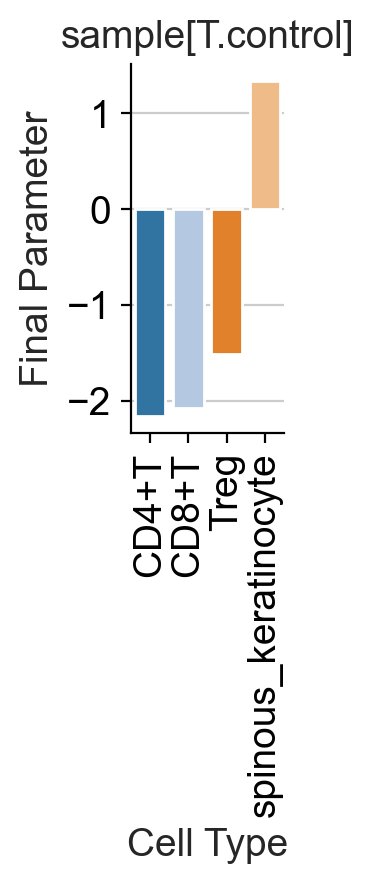

In [37]:
sccoda_model.plot_effects_barplot(sccoda_data, modality_key="coda", parameter="Final Parameter")

**Interpretation:** In the control, there is an credible decrease of CD4+T, CD8+T, Treg and an credible increase of spinous_keratinocyte, while other cells are uneffected by the diseases. The log-fold change of CD4+T, CD8+T, Treg, and spinous keratinocyte between control and case with the same total cell count lies at about -2.253, -2.130, -1.317, 2.785.

The cutoff between credible and non-credible effects depends on the desired false discovery rate (FDR). A smaller FDR value will produce more conservative results, but might miss some effects, while a larger FDR value selects more effects at the cost of a larger number of false discoveries.

In [38]:
#Per default, the value is 0.05., => less strict FDR =0.2
sccoda_model.set_fdr(sccoda_data, 0.2)

In [39]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda")

Covariate          Cell Type            
sample[T.control]  CD4+T                     True
                   CD8+T                     True
                   HFDPC                    False
                   HF_keratinocyte           True
                   M1_macrophage            False
                   Treg                      True
                   basal_keratinocyte       False
                   dendritic_cell           False
                   dermal_fibroblast         True
                   dermal_sheath             True
                   lymphatic_endothelium    False
                   macrophage                True
                   mast_cell                 True
                   melanocyte               False
                   myocyte                  False
                   pericyte                 False
                   plasma_cell               True
                   spinous_keratinocyte      True
                   vascular_endothelium     False
Name: Fin

In [40]:
sccoda_model.summary(sccoda_data, modality_key="coda")

                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 2 samples, 19 cell types                                    │
│ Reference cell type                         │ lymphatic_endothelium                                             │
│ Formula                                     │ sample                                                            │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                        Final Parameter  Expected Sample                                                         │
│ Cell Type                                                                                                       │
│ CD4+T                      4.519           1277.581                                                             │
│ CD8+T                      3.593            506.095                                                             │
│ HFDPC                      1.173             45.003                                                             │
│ HF_keratinocyte            0.279             18.407                                                             │
│ M1_macrophage              0.356             19.880                                                             │
│ Treg                       2.885            249.317                                                             │
│ basal_keratinocyte         1.568             66.801                                                             │
│ dendritic_cell             1.993            102.179                                                             │
│ dermal_fibroblast          2.912            256.140                                                             │
│ dermal_sheath              1.558             66.137                                                             │
│ lymphatic_endothelium      0.642             26.462                                                             │
│ macrophage                 2.243            131.200                                                             │
│ mast_cell                  1.535             64.633                                                             │
│ melanocyte                 1.328             52.548                                                             │
│ myocyte                    2.473            165.128                                                             │
│ pericyte                   1.130             43.109                                                             │
│ plasma_cell                0.466             22.192                                                             │
│ spinous_keratinocyte       1.911             94.134                                                             │
│ vascular_endothelium       2.326            142.554                                                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                        Final Parameter  Expected Sample  log2-fold change                       │
│ Covariate       Cell Type                                                                                       │
│ sampleT.control CD4+T                      -2.157          198.238            -2.688                            │
│                 CD8+T                      -2.072           85.531            -2.565                            │
│                 HFDPC                       0.000           60.386             0.424                            │
│                 HF_keratinocyte             1.488          109.339             2.570                            │
│                 M1_macrophage               0.000           26.676             0.424                            │
│                 Treg                       -1.508           74.026            -1.752                            │
│                 basal_keratinocyte          0.000           89.636             0.424                            │
│                 dendritic_cell              0.000          137.106             0.424                            │
│                 dermal_fibroblast           0.820          780.204             1.607                            │
│                 dermal_sheath              -0.791           40.216            -0.718                            │
│                 lymphatic_endothelium       0.000           35.508             0.424                            │
│                 macrophage                  0.730          365.171             1.477                            │
│                 mast_cell                   1.291          315.510             2.287                            │
│                 melanocyte                  0.000           70.510             0.424                            │
│                 myocyte                     0.000          221.573             0.424                            │
│                 pericyte                    0.000           57.844             0.424                            │
│                 plasma_cell                -1.016           10.780            -1.042                            │
│                 spinous_keratinocyte        1.335          479.966             2.350                            │
│                 vascular_endothelium        0.000          191.283             0.424                            │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

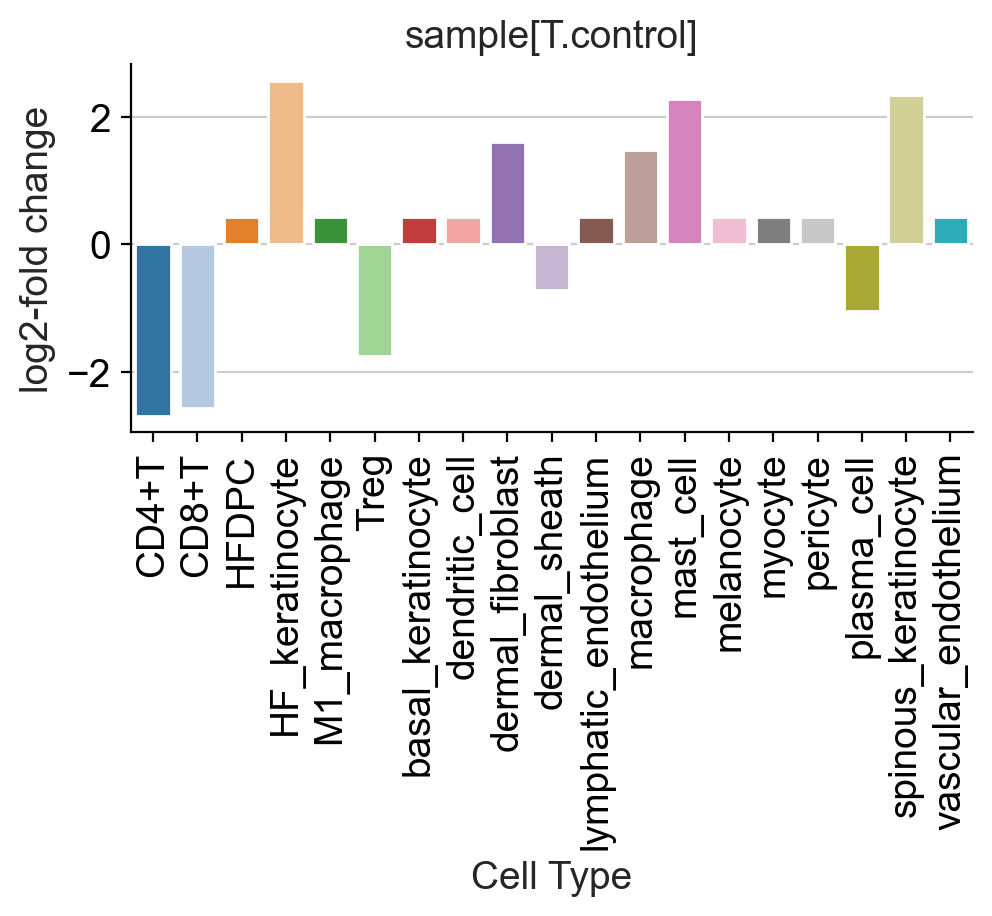

In [43]:
sccoda_model.plot_effects_barplot(sccoda_data, modality_key="coda")

This result corresponds with the publication, which mentioned that 'samples from patients with alopecia areata had increased T lymphocytes and depletion of follicular keratinocytes.' These observations align with the pathophysiology of alopecia areata, which involves peribulbar hair follicle T-cell infiltration and disruption of normal hair follicle cycling.

**note** the cell count data is compositional and therefore an increase in the relative abundance of one cell type will lead to a decrease in the relative abundance of all other cell types. 
scCODA is used to statistically evaluate changes in abundance (to observe compositional changes)

In [61]:
#saving result
#sccoda_data.write_h5mu('sccoda_data')

In [62]:
#read
#sccoda_data = mu.read_h5mu('sccoda_data')

## 3. Differential gene expression analysis

#### 3.1. compare case and control using scvi

In [5]:
adata.raw = adata

In [6]:
adata

AnnData object with n_obs × n_vars = 6699 × 33538
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'sample', 'celltypist_skin_label', 'celltypist_conf_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'celltypist_skin_major', 'manual_label'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_skin_label_colors', 'celltypist_skin_major_colors', 'log1p', 'manual_label_colors', 'neighbors', 'overcluster', 'overcluster_colors', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'log1p_norm'
    obsp: 'connectivities', 'distances'

In [7]:
#use raw count matrix
scvi.data.poisson_gene_selection(adata, layer='counts')

Sampling from binomial...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.94it/s]


In [8]:
adata

AnnData object with n_obs × n_vars = 6699 × 33538
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'sample', 'celltypist_skin_label', 'celltypist_conf_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'celltypist_skin_major', 'manual_label'
    var: 'highly_variable', 'observed_fraction_zeros', 'expected_fraction_zeros', 'prob_zero_enriched_nbatches', 'prob_zero_enrichment', 'prob_zero_enrichment_rank'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_skin_label_colors', 'celltypist_skin_major_colors', 'log1p', 'manual_label_colors', 'neighbors', 'overcluster', 'overcluster_colors', 'rank_genes_groups', 'sample_colors', 'umap', 'hvg'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'log1p_norm'
    obsp: 'connectivities', 'distances'

In [8]:
#subset to highly variable genes
adata = adata[:, adata.var.highly_variable].copy()

In [9]:
adata

AnnData object with n_obs × n_vars = 6699 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'sample', 'celltypist_skin_label', 'celltypist_conf_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'celltypist_skin_major', 'manual_label'
    var: 'highly_variable', 'observed_fraction_zeros', 'expected_fraction_zeros', 'prob_zero_enriched_nbatches', 'prob_zero_enrichment', 'prob_zero_enrichment_rank'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_skin_label_colors', 'celltypist_skin_major_colors', 'log1p', 'manual_label_colors', 'neighbors', 'overcluster', 'overcluster_colors', 'rank_genes_groups', 'sample_colors', 'umap', 'hvg'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'log1p_norm'
    obsp: 'connectivities', 'distances'

In [10]:
adata.raw.to_adata()

AnnData object with n_obs × n_vars = 6699 × 33538
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'sample', 'celltypist_skin_label', 'celltypist_conf_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'celltypist_skin_major', 'manual_label'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_skin_label_colors', 'celltypist_skin_major_colors', 'log1p', 'manual_label_colors', 'neighbors', 'overcluster', 'overcluster_colors', 'rank_genes_groups', 'sample_colors', 'umap', 'hvg'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    obsp: 'connectivities', 'distances'

In [11]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="sample")

In [12]:
model = scvi.model.SCVI(adata)

In [13]:
model.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.5.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'sample',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   2   │
│         n_cells          │ 6699  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 4000  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    case    │          0          │
│                     │  control   │          1          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [14]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|███████████████████████████████████████████| 400/400 [31:27<00:00,  5.62s/it, v_num=1, train_loss_step=2.98e+3, train_loss_epoch=3.17e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████████████████| 400/400 [31:27<00:00,  4.72s/it, v_num=1, train_loss_step=2.98e+3, train_loss_epoch=3.17e+3]


In [15]:
adata.obsm['X_scVI'] = model.get_latent_representation()

In [16]:
#get the scvi normalized expression
adata.layers['scVI_expr'] = model.get_normalized_expression(library_size = 1e4)

In [17]:
#save model 
model.save('model.model')

In [18]:
adata.write('annotated_trained_highlyvar.h5ad')

In [19]:
sc.pp.neighbors(adata, use_rep='X_scVI')
sc.tl.umap(adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


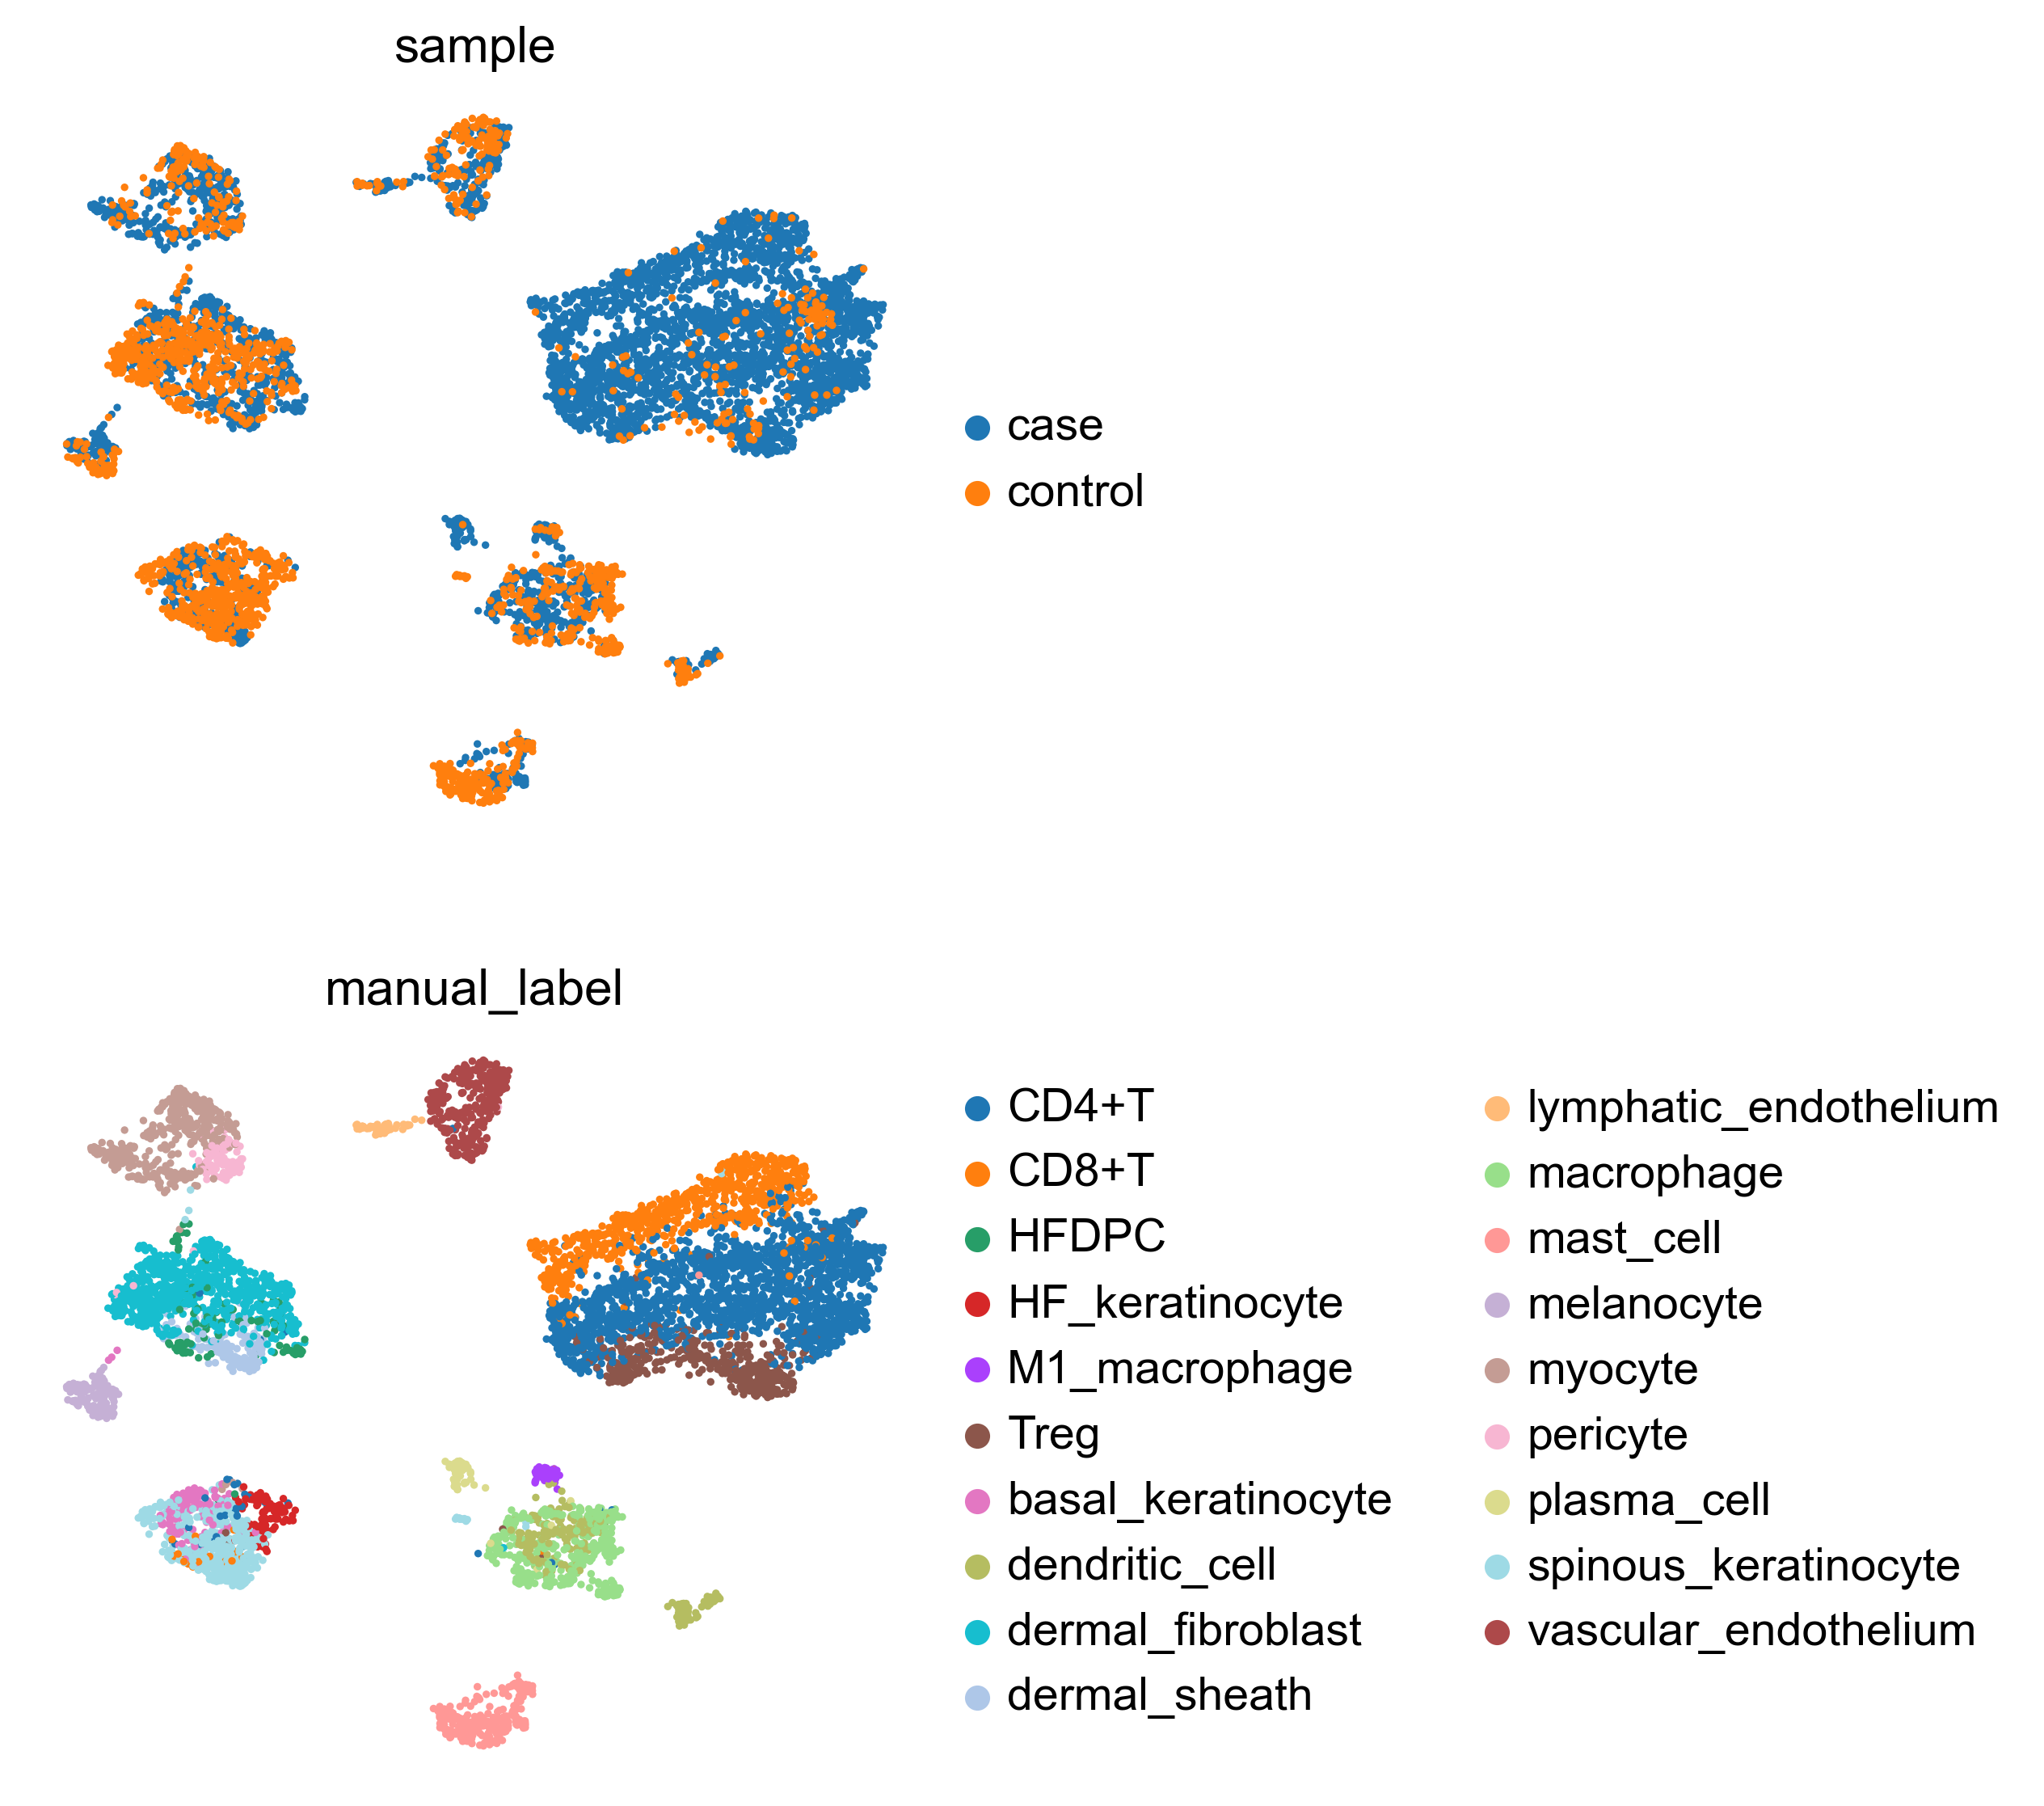

In [20]:
sc.pl.umap(adata, color=['sample', 'manual_label'], ncols =1)

**Comparation between CASE and CONTROL**

In [96]:
adata = sc.read_h5ad('annotated_trained_highlyvar.h5ad')

In [97]:
#reload trained model
model =  scvi.model.SCVI.load('model.model', adata = adata)

INFO     File model.model/model.pt already downloaded                                                              


In [98]:
#DE testing
scvi_DE_case_control = model.differential_expression(
            idx1 = [adata.obs['sample'] == 'case'],
            idx2 = [adata.obs['sample'] == 'control'])

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.86s/it]


In [99]:
scvi_DE_case_control

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
XIST       0.9974        0.0026      5.949637  0.000050  0.000860   
RPS4Y1     0.9894        0.0106      4.536244  0.001293  0.000315   
IFNG       0.9774        0.0226      3.766946  0.000509  0.000021   
GIMAP7     0.9772        0.0228      3.757930  0.000393  0.000052   
ACKR3      0.9772        0.0228      3.757930  0.000044  0.000275   
...           ...           ...           ...       ...       ...   
ARF1       0.6516        0.3484      0.626080  0.000421  0.000478   
TMBIM6     0.6342        0.3658      0.550278  0.000648  0.000724   
PCBP2      0.6164        0.3836      0.474296  0.000616  0.000545   
KHDRBS1    0.6126        0.3874      0.458254  0.000327  0.000298   
ST13       0.6020        0.3980      0.413805  0.000552  0.000597   

         pseudocounts  delta  lfc_mean  lfc_median   lfc_std    lfc_min  \
XIST              0.0   0.25 -4.585526   -4.658447  1.595477  -9.561450   
RPS4Y1            0.0   0.25  2.050233    2.036742  0.838337  -1.408212   
IFNG              0.0   0.25  4.731485    4.889050  3.704890  -9.114237   
GIMAP7            0.0   0.25  4.029181    4.398504  3.068256  -7.100127   
ACKR3             0.0   0.25 -3.811932   -4.090562  3.217842 -13.941073   
...               ...    ...       ...         ...       ...        ...   
ARF1              0.0   0.25 -0.156033   -0.190742  0.491285  -1.759791   
TMBIM6            0.0   0.25 -0.163180   -0.152851  0.500583  -1.791729   
PCBP2             0.0   0.25  0.176824    0.174873  0.475685  -1.598953   
KHDRBS1           0.0   0.25  0.141080    0.140017  0.489621  -2.400284   
ST13              0.0   0.25 -0.108808   -0.135084  0.481499  -1.793992   

           lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
XIST      1.283427   0.000416   4.913751               0.000416   
RPS4Y1    5.579291   2.912227   0.000000               0.821169   
IFNG     15.940703   0.848410   0.024339               0.144521   
GIMAP7   11.723883   0.509667   0.119048               0.231233   
ACKR3     7.950724   0.110418   1.811639               0.052194   
...            ...        ...        ...                    ...   
ARF1      1.857915   1.133704   3.114272               0.552714   
TMBIM6    1.580885   1.697630   4.690999               0.662508   
PCBP2     1.989081   1.818236   3.761894               0.656685   
KHDRBS1   1.988421   0.867750   1.931743               0.464130   
ST13      2.402204   1.530864   3.884642               0.594926   

         non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
XIST                  0.858730              0.002465             10.071143   
RPS4Y1                0.000000             13.249529              0.000000   
IFNG                  0.007937              6.501285              0.130705   
GIMAP7                0.051852              3.282600              0.332802   
ACKR3                 0.260847              0.306823              2.823567   
...                        ...                   ...                   ...   
ARF1                  0.801587              4.458943              4.947665   
TMBIM6                0.865079              6.935118              7.489788   
PCBP2                 0.837566              6.904564              5.934144   
KHDRBS1               0.673016              3.592874              3.086121   
ST13                  0.841270              5.984199              6.658614   

         is_de_fdr_0.05  
XIST               True  
RPS4Y1             True  
IFNG               True  
GIMAP7             True  
ACKR3              True  
...                 ...  
ARF1              False  
TMBIM6            False  
PCBP2             False  
KHDRBS1           False  
ST13              False  

[4000 rows x 19 columns]

In [100]:
#Volcano plot of change mode DE with p-value
# manipulate the DE results for plotting
scvi_DE_case_control["log10_pscore"] = np.log10(scvi_DE_case_control["proba_not_de"])
scvi_DE_case_control = scvi_DE_case_control.join(adata.var, how="inner")
scvi_DE_case_control.head()

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
XIST      0.9974        0.0026      5.949637  0.000050  0.000860   
RPS4Y1    0.9894        0.0106      4.536244  0.001293  0.000315   
IFNG      0.9774        0.0226      3.766946  0.000509  0.000021   
GIMAP7    0.9772        0.0228      3.757930  0.000393  0.000052   
ACKR3     0.9772        0.0228      3.757930  0.000044  0.000275   

        pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  \
XIST             0.0   0.25 -4.585526   -4.658447  1.595477  ...   
RPS4Y1           0.0   0.25  2.050233    2.036742  0.838337  ...   
IFNG             0.0   0.25  4.731485    4.889050  3.704890  ...   
GIMAP7           0.0   0.25  4.029181    4.398504  3.068256  ...   
ACKR3            0.0   0.25 -3.811932   -4.090562  3.217842  ...   

        raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
XIST                0.002465             10.071143            True   
RPS4Y1             13.249529              0.000000            True   
IFNG                6.501285              0.130705            True   
GIMAP7              3.282600              0.332802            True   
ACKR3               0.306823              2.823567            True   

        log10_pscore  highly_variable  observed_fraction_zeros  \
XIST       -2.585027             True                 0.757426   
RPS4Y1     -1.974694             True                 0.410509   
IFNG       -1.645892             True                 0.894014   
GIMAP7     -1.642065             True                 0.819376   
ACKR3      -1.642065             True                 0.888939   

        expected_fraction_zeros  prob_zero_enriched_nbatches  \
XIST                   0.387567                            1   
RPS4Y1                 0.277000                            1   
IFNG                   0.607381                            1   
GIMAP7                 0.708477                            1   
ACKR3                  0.617974                            1   

        prob_zero_enrichment  prob_zero_enrichment_rank  
XIST                  0.4646                    33390.0  
RPS4Y1                0.2938                    32760.0  
IFNG                  0.3478                    33177.0  
GIMAP7                0.2431                    31634.0  
ACKR3                 0.3305                    33097.0  

[5 rows x 26 columns]

In [101]:
def label_gene(row):
    if (row['lfc_mean'] > 1.5) and (row['is_de_fdr_0.05'] == True):
        return 'UP'
    elif (row['lfc_mean'] < -1.5) and (row['is_de_fdr_0.05'] == True):
        return 'DOWN'
    else:
        return 'NOdiff'

In [102]:
# Apply the function to each row in the dataframe
scvi_DE_case_control['diff_expr'] = scvi_DE_case_control.apply(label_gene, axis=1)

In [103]:
# Filter out rows where log10_pscore is -inf
scvi_DE_case_control_plot = scvi_DE_case_control[scvi_DE_case_control["log10_pscore"] != -np.inf]
scvi_DE_case_control_plot

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
XIST       0.9974        0.0026      5.949637  0.000050  0.000860   
RPS4Y1     0.9894        0.0106      4.536244  0.001293  0.000315   
IFNG       0.9774        0.0226      3.766946  0.000509  0.000021   
GIMAP7     0.9772        0.0228      3.757930  0.000393  0.000052   
ACKR3      0.9772        0.0228      3.757930  0.000044  0.000275   
...           ...           ...           ...       ...       ...   
ARF1       0.6516        0.3484      0.626080  0.000421  0.000478   
TMBIM6     0.6342        0.3658      0.550278  0.000648  0.000724   
PCBP2      0.6164        0.3836      0.474296  0.000616  0.000545   
KHDRBS1    0.6126        0.3874      0.458254  0.000327  0.000298   
ST13       0.6020        0.3980      0.413805  0.000552  0.000597   

         pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  \
XIST              0.0   0.25 -4.585526   -4.658447  1.595477  ...   
RPS4Y1            0.0   0.25  2.050233    2.036742  0.838337  ...   
IFNG              0.0   0.25  4.731485    4.889050  3.704890  ...   
GIMAP7            0.0   0.25  4.029181    4.398504  3.068256  ...   
ACKR3             0.0   0.25 -3.811932   -4.090562  3.217842  ...   
...               ...    ...       ...         ...       ...  ...   
ARF1              0.0   0.25 -0.156033   -0.190742  0.491285  ...   
TMBIM6            0.0   0.25 -0.163180   -0.152851  0.500583  ...   
PCBP2             0.0   0.25  0.176824    0.174873  0.475685  ...   
KHDRBS1           0.0   0.25  0.141080    0.140017  0.489621  ...   
ST13              0.0   0.25 -0.108808   -0.135084  0.481499  ...   

         raw_normalized_mean2  is_de_fdr_0.05  log10_pscore  highly_variable  \
XIST                10.071143            True     -2.585027             True   
RPS4Y1               0.000000            True     -1.974694             True   
IFNG                 0.130705            True     -1.645892             True   
GIMAP7               0.332802            True     -1.642065             True   
ACKR3                2.823567            True     -1.642065             True   
...                       ...             ...           ...              ...   
ARF1                 4.947665           False     -0.457922             True   
TMBIM6               7.489788           False     -0.436756             True   
PCBP2                5.934144           False     -0.416121             True   
KHDRBS1              3.086121           False     -0.411840             True   
ST13                 6.658614           False     -0.400117             True   

         observed_fraction_zeros  expected_fraction_zeros  \
XIST                    0.757426                 0.387567   
RPS4Y1                  0.410509                 0.277000   
IFNG                    0.894014                 0.607381   
GIMAP7                  0.819376                 0.708477   
ACKR3                   0.888939                 0.617974   
...                          ...                      ...   
ARF1                    0.377071                 0.332901   
TMBIM6                  0.280340                 0.228219   
PCBP2                   0.292282                 0.245669   
KHDRBS1                 0.476937                 0.435290   
ST13                    0.335572                 0.264542   

         prob_zero_enriched_nbatches  prob_zero_enrichment  \
XIST                               1                0.4646   
RPS4Y1                             1                0.2938   
IFNG                               1                0.3478   
GIMAP7                             1                0.2431   
ACKR3                              1                0.3305   
...                              ...                   ...   
ARF1                               1                0.2491   
TMBIM6                             1                0.2155   
PCBP2                              1                0.2176   
KHDRBS1                            1 

In [104]:
#create new column column
scvi_DE_case_control_plot['delabel'] = ''

In [105]:
#The values in the gene_symbol column are assigned to delabel for the rows where diffexpressed is not "NOdiff".
scvi_DE_case_control_plot.loc[scvi_DE_case_control_plot['diff_expr'] != 'NOdiff', 'delabel'] = scvi_DE_case_control_plot.index[scvi_DE_case_control_plot['diff_expr'] != 'NOdiff']

In [106]:
scvi_DE_case_control_plot

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
XIST       0.9974        0.0026      5.949637  0.000050  0.000860   
RPS4Y1     0.9894        0.0106      4.536244  0.001293  0.000315   
IFNG       0.9774        0.0226      3.766946  0.000509  0.000021   
GIMAP7     0.9772        0.0228      3.757930  0.000393  0.000052   
ACKR3      0.9772        0.0228      3.757930  0.000044  0.000275   
...           ...           ...           ...       ...       ...   
ARF1       0.6516        0.3484      0.626080  0.000421  0.000478   
TMBIM6     0.6342        0.3658      0.550278  0.000648  0.000724   
PCBP2      0.6164        0.3836      0.474296  0.000616  0.000545   
KHDRBS1    0.6126        0.3874      0.458254  0.000327  0.000298   
ST13       0.6020        0.3980      0.413805  0.000552  0.000597   

         pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  \
XIST              0.0   0.25 -4.585526   -4.658447  1.595477  ...   
RPS4Y1            0.0   0.25  2.050233    2.036742  0.838337  ...   
IFNG              0.0   0.25  4.731485    4.889050  3.704890  ...   
GIMAP7            0.0   0.25  4.029181    4.398504  3.068256  ...   
ACKR3             0.0   0.25 -3.811932   -4.090562  3.217842  ...   
...               ...    ...       ...         ...       ...  ...   
ARF1              0.0   0.25 -0.156033   -0.190742  0.491285  ...   
TMBIM6            0.0   0.25 -0.163180   -0.152851  0.500583  ...   
PCBP2             0.0   0.25  0.176824    0.174873  0.475685  ...   
KHDRBS1           0.0   0.25  0.141080    0.140017  0.489621  ...   
ST13              0.0   0.25 -0.108808   -0.135084  0.481499  ...   

         is_de_fdr_0.05  log10_pscore  highly_variable  \
XIST               True     -2.585027             True   
RPS4Y1             True     -1.974694             True   
IFNG               True     -1.645892             True   
GIMAP7             True     -1.642065             True   
ACKR3              True     -1.642065             True   
...                 ...           ...              ...   
ARF1              False     -0.457922             True   
TMBIM6            False     -0.436756             True   
PCBP2             False     -0.416121             True   
KHDRBS1           False     -0.411840             True   
ST13              False     -0.400117             True   

         observed_fraction_zeros  expected_fraction_zeros  \
XIST                    0.757426                 0.387567   
RPS4Y1                  0.410509                 0.277000   
IFNG                    0.894014                 0.607381   
GIMAP7                  0.819376                 0.708477   
ACKR3                   0.888939                 0.617974   
...                          ...                      ...   
ARF1                    0.377071                 0.332901   
TMBIM6                  0.280340                 0.228219   
PCBP2                   0.292282                 0.245669   
KHDRBS1                 0.476937                 0.435290   
ST13                    0.335572                 0.264542   

         prob_zero_enriched_nbatches  prob_zero_enrichment  \
XIST                               1                0.4646   
RPS4Y1                             1                0.2938   
IFNG                               1                0.3478   
GIMAP7                             1                0.2431   
ACKR3                              1                0.3305   
...                              ...                   ...   
ARF1                               1                0.2491   
TMBIM6                             1                0.2155   
PCBP2                              1                0.2176   
KHDRBS1                            1                0.2705   
ST13                               1                0.2427   

         prob_zero_enrichment_rank  diff_expr  delabel  
XIST                       33390.0       DOWN     XIST  
RPS4Y1                     32760.0         UP   RPS4Y1  
IFNG 

In [107]:
#plotnine is an implementation of a grammar of graphics in Python based on ggplot2
import plotnine as p9

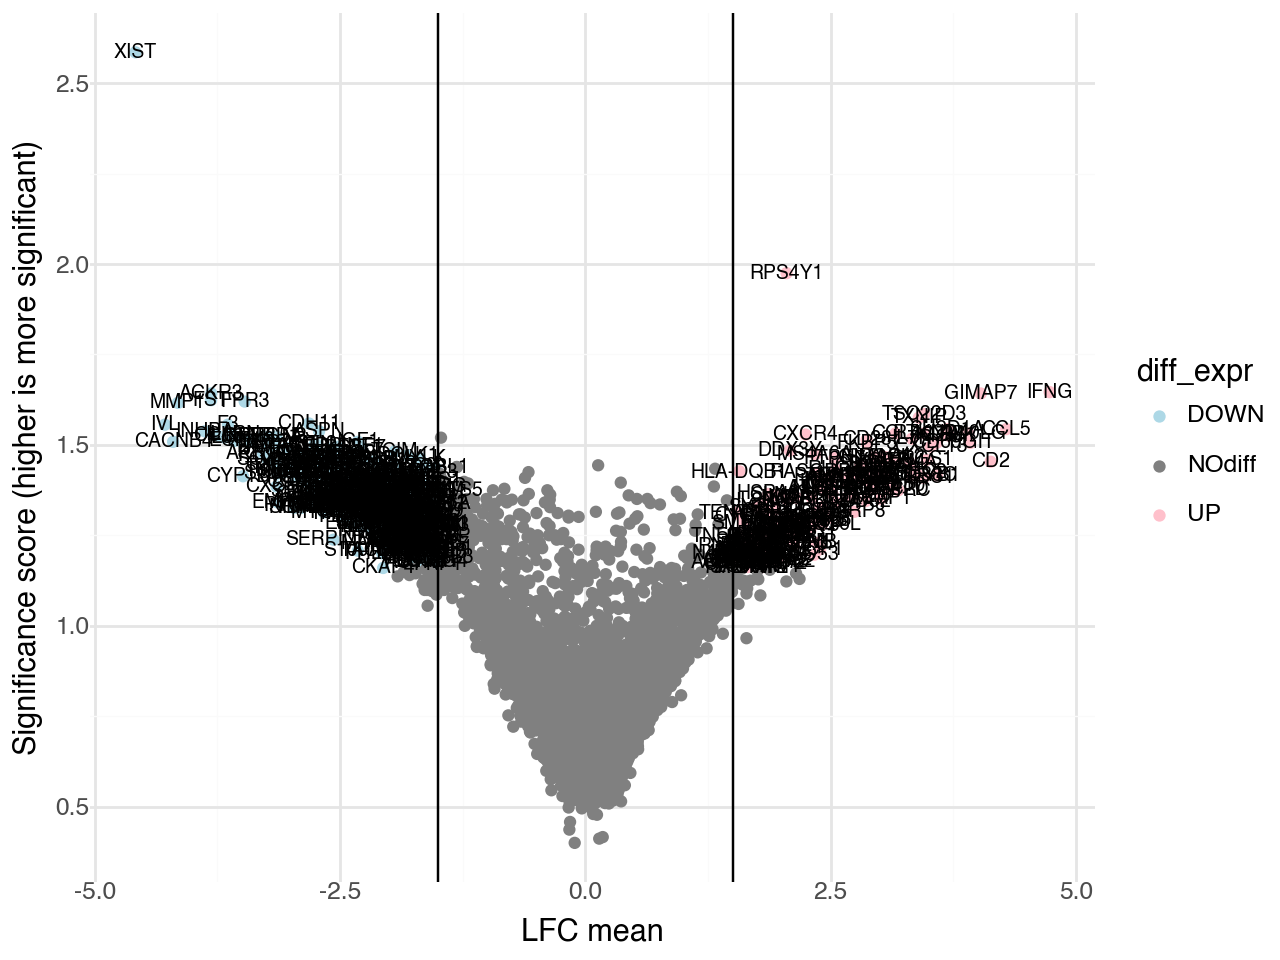

In [108]:
#use -log10 p-value
custom_colors = {"UP": "pink", "DOWN": "lightblue", "NOdiff": "gray"}
(
    p9.ggplot(scvi_DE_case_control_plot, p9.aes("lfc_mean", "-log10_pscore", color='diff_expr', label='delabel'))
    + p9.geom_point()
    + p9.geom_text(size=7, color='black')
    + p9.theme_minimal()
    + p9.scale_color_manual(values=custom_colors)
    + p9.geom_vline(xintercept = (-1.5, 1.5))
    + p9.labs(x="LFC mean", y="Significance score (higher is more significant)")
    #+ p9.geom_hline(yintercept = 0.05)
)

In [109]:
#create new column column
scvi_DE_case_control_plot['delabel_top20'] = ''

In [110]:
# Filter the DataFrame based on the 'diff_expr' condition
filtered_df = scvi_DE_case_control_plot[scvi_DE_case_control_plot['diff_expr'] != 'NOdiff']

# Sort the filtered DataFrame by 'log10_pscore' in descending order and select the top 20
top20_df = filtered_df.nsmallest(20, 'log10_pscore')

# Create a boolean mask for the top 20 entries
mask = scvi_DE_case_control_plot.index.isin(top20_df.index)

# Update 'delabel_top20' only for the top 20 entries
scvi_DE_case_control_plot.loc[mask, 'delabel_top20'] = scvi_DE_case_control_plot.index[mask]


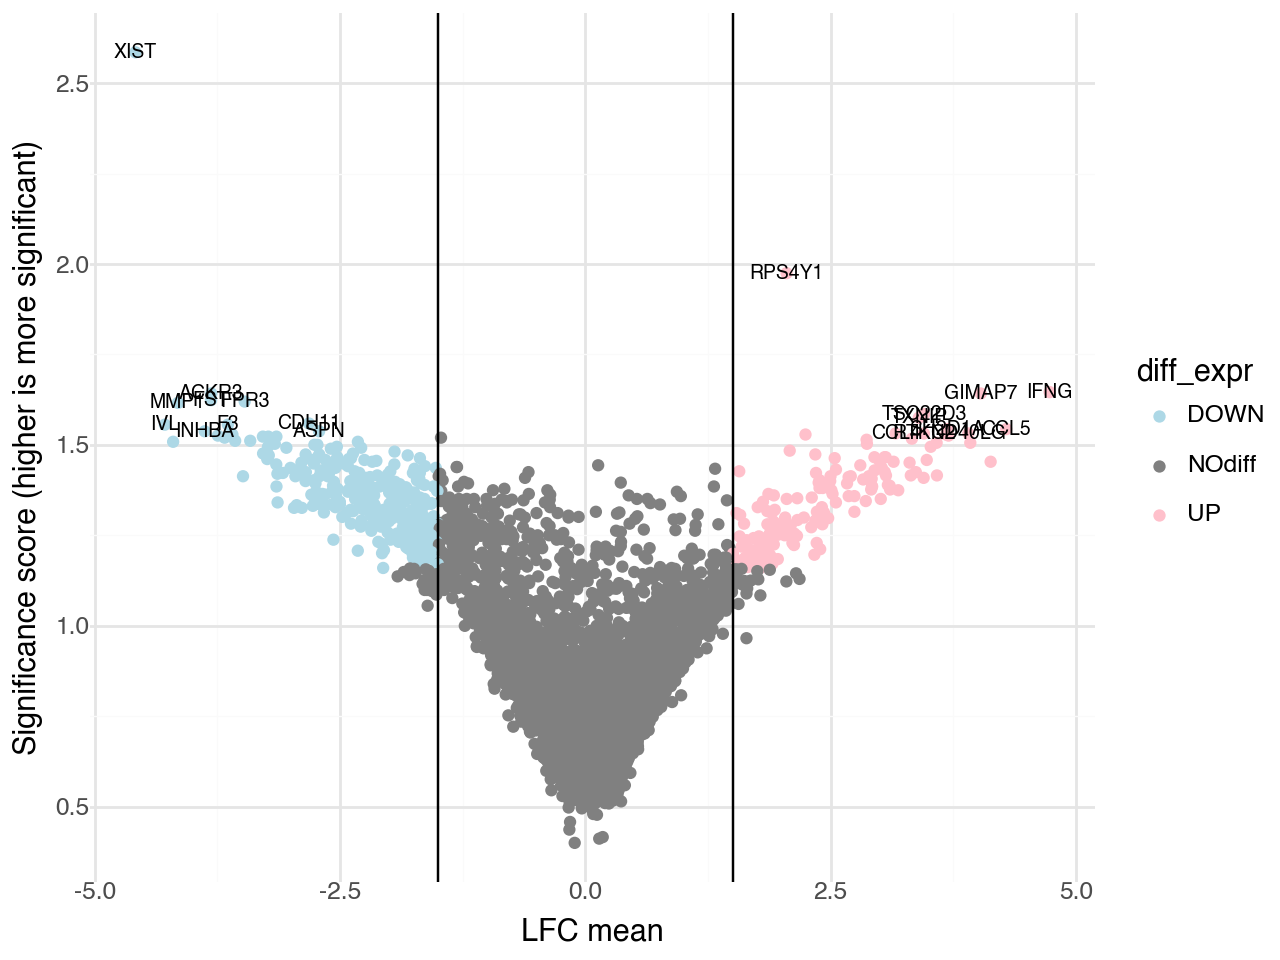

In [111]:
#use -log10 p-value
custom_colors = {"UP": "pink", "DOWN": "lightblue", "NOdiff": "gray"}
(
    p9.ggplot(scvi_DE_case_control_plot, p9.aes("lfc_mean", "-log10_pscore", color='diff_expr', label='delabel_top20'))
    + p9.geom_point()
    + p9.geom_text(size=7, color='black')
    + p9.theme_minimal()
    + p9.scale_color_manual(values=custom_colors)
    + p9.geom_vline(xintercept = (-1.5, 1.5))
    + p9.labs(x="LFC mean", y="Significance score (higher is more significant)")
    #+ p9.geom_hline(yintercept = 0.05)
)

**Heatmap**

I selected the genes that have FDR-corrected p-value under 0.05 and log-fold change of over 1.5 (both upregulated and downregulated genes)

In [112]:
scvi_DE_case_control = scvi_DE_case_control[(scvi_DE_case_control['is_de_fdr_0.05'] == True) & (abs(scvi_DE_case_control['lfc_mean']) > 1.5)]
scvi_DE_case_control = scvi_DE_case_control.sort_values('lfc_mean')
scvi_DE_case_control

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
XIST      0.9974        0.0026      5.949637  0.000050  0.000860   
IVL       0.9722        0.0278      3.554525  0.000004  0.000069   
CACNB4    0.9690        0.0310      3.442277  0.000025  0.000121   
MMP1      0.9758        0.0242      3.696905  0.000013  0.000175   
INHBA     0.9710        0.0290      3.511030  0.000104  0.000529   
...          ...           ...           ...       ...       ...   
TIGIT     0.9688        0.0312      3.435640  0.000254  0.000049   
GIMAP7    0.9772        0.0228      3.757930  0.000393  0.000052   
CD2       0.9648        0.0352      3.310874  0.001220  0.000195   
CCL5      0.9714        0.0286      3.525331  0.001261  0.000072   
IFNG      0.9774        0.0226      3.766946  0.000509  0.000021   

        pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  \
XIST             0.0   0.25 -4.585526   -4.658447  1.595477  ...   
IVL              0.0   0.25 -4.285683   -4.369633  5.618595  ...   
CACNB4           0.0   0.25 -4.201454   -4.627429  4.850873  ...   
MMP1             0.0   0.25 -4.152089   -4.357307  4.461410  ...   
INHBA            0.0   0.25 -3.879326   -4.194257  4.723012  ...   
...              ...    ...       ...         ...       ...  ...   
TIGIT            0.0   0.25  3.922851    4.518146  4.261229  ...   
GIMAP7           0.0   0.25  4.029181    4.398504  3.068256  ...   
CD2              0.0   0.25  4.130160    4.771734  4.062956  ...   
CCL5             0.0   0.25  4.289119    4.331449  4.054559  ...   
IFNG             0.0   0.25  4.731485    4.889050  3.704890  ...   

        raw_normalized_mean2  is_de_fdr_0.05  log10_pscore  highly_variable  \
XIST               10.071143            True     -2.585027             True   
IVL                 0.608153            True     -1.555955             True   
CACNB4              0.807226            True     -1.508638             True   
MMP1                1.488621            True     -1.616185             True   
INHBA               3.560548            True     -1.537602             True   
...                      ...             ...           ...              ...   
TIGIT               0.376590            True     -1.505845             True   
GIMAP7              0.332802            True     -1.642065             True   
CD2                 1.684530            True     -1.453457             True   
CCL5                0.481730            True     -1.543634             True   
IFNG                0.130705            True     -1.645892             True   

        observed_fraction_zeros  expected_fraction_zeros  \
XIST                   0.757426                 0.387567   
IVL                    0.973280                 0.772052   
CACNB4                 0.891626                 0.786309   
MMP1                   0.980445                 0.714499   
INHBA                  0.897447                 0.508893   
...                         ...                      ...   
TIGIT                  0.878639                 0.812716   
GIMAP7                 0.819376                 0.708477   
CD2                    0.630691                 0.415116   
CCL5                   0.834602                 0.433376   
IFNG                   0.894014                 0.607381   

        prob_zero_enriched_nbatches  prob_zero_enrichment  \
XIST                              1                0.4646   
IVL                               1                0.2202   
CACNB4                            1                0.1876   
MMP1                              1                0.2768   
INHBA                             1                0.4353   
...                             ...                   ...   
TIGIT                             1                0.1637   
GIMAP7                            1                0.2431   
CD2                               1                0.3742   
CCL5                              1                0.4783   
IFNG                             

In [113]:
#get top 25 and bottom 25 genes
genes_to_show = scvi_DE_case_control[-25:].index.tolist() + scvi_DE_case_control[:25].index.tolist()

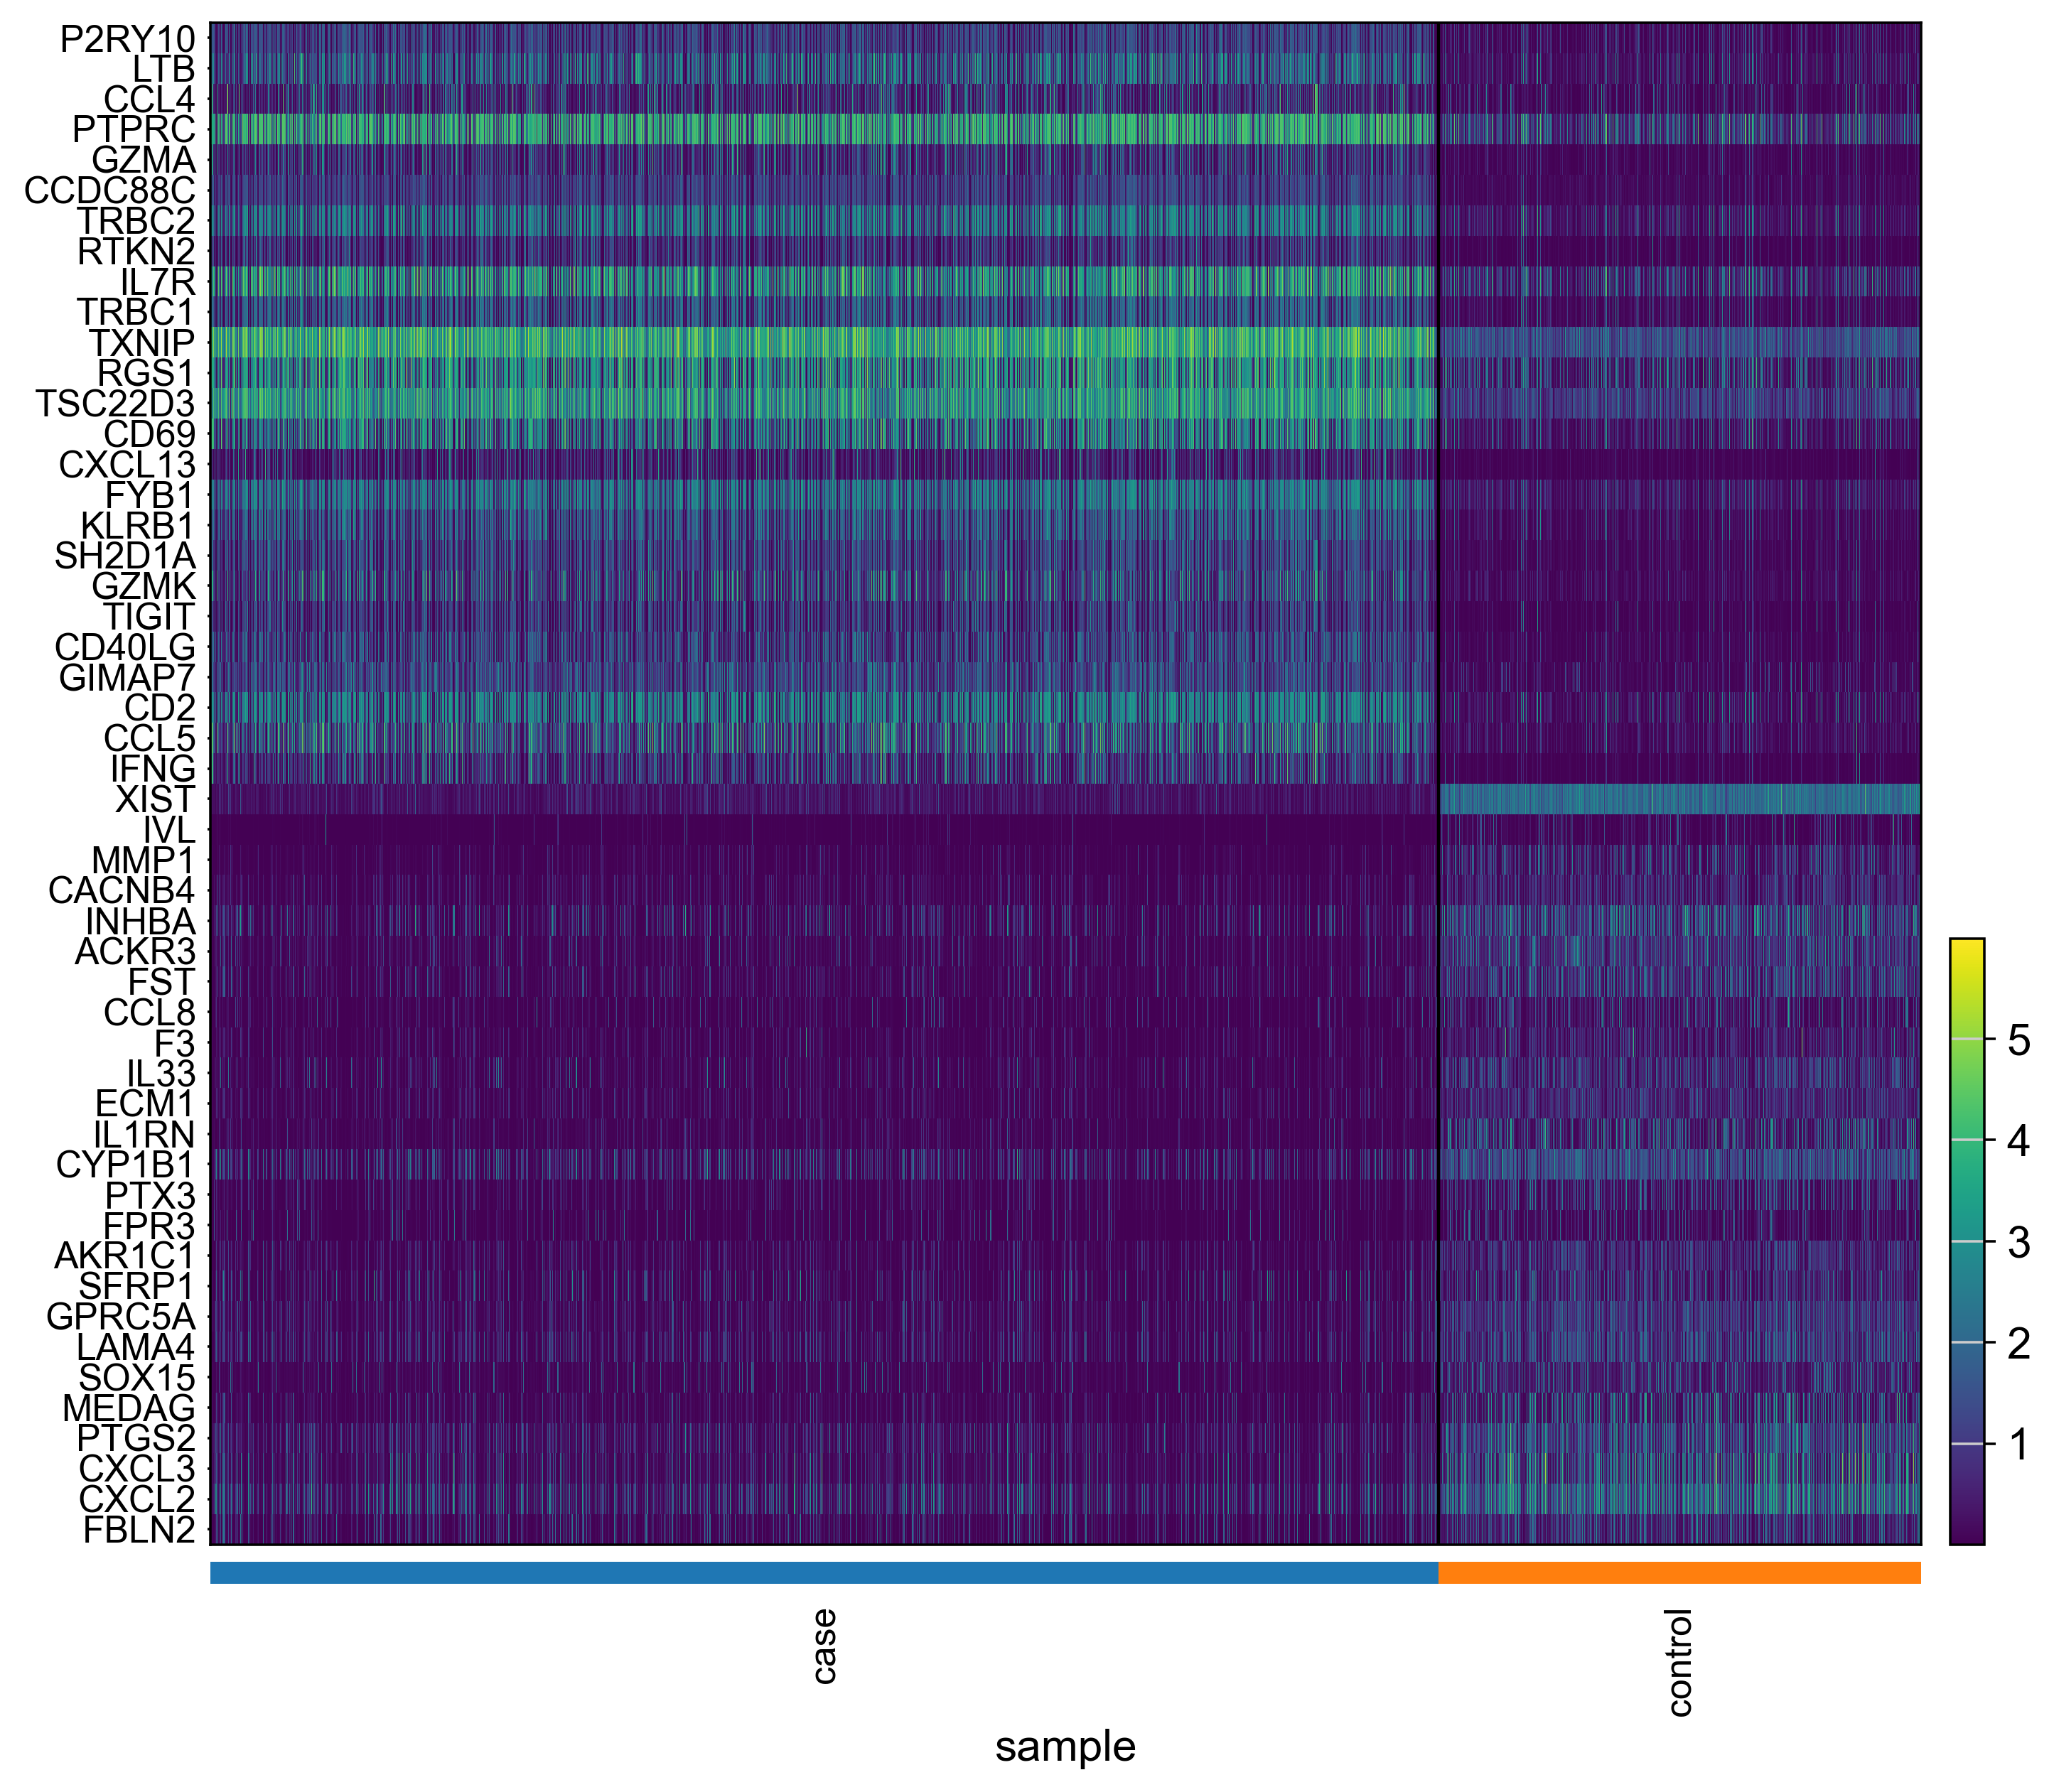

In [37]:
#plot the heat map differential expression between case vs control
sc.pl.heatmap(adata, genes_to_show, groupby='sample', swap_axes=True, layer='scVI_expr',\
             log=True)

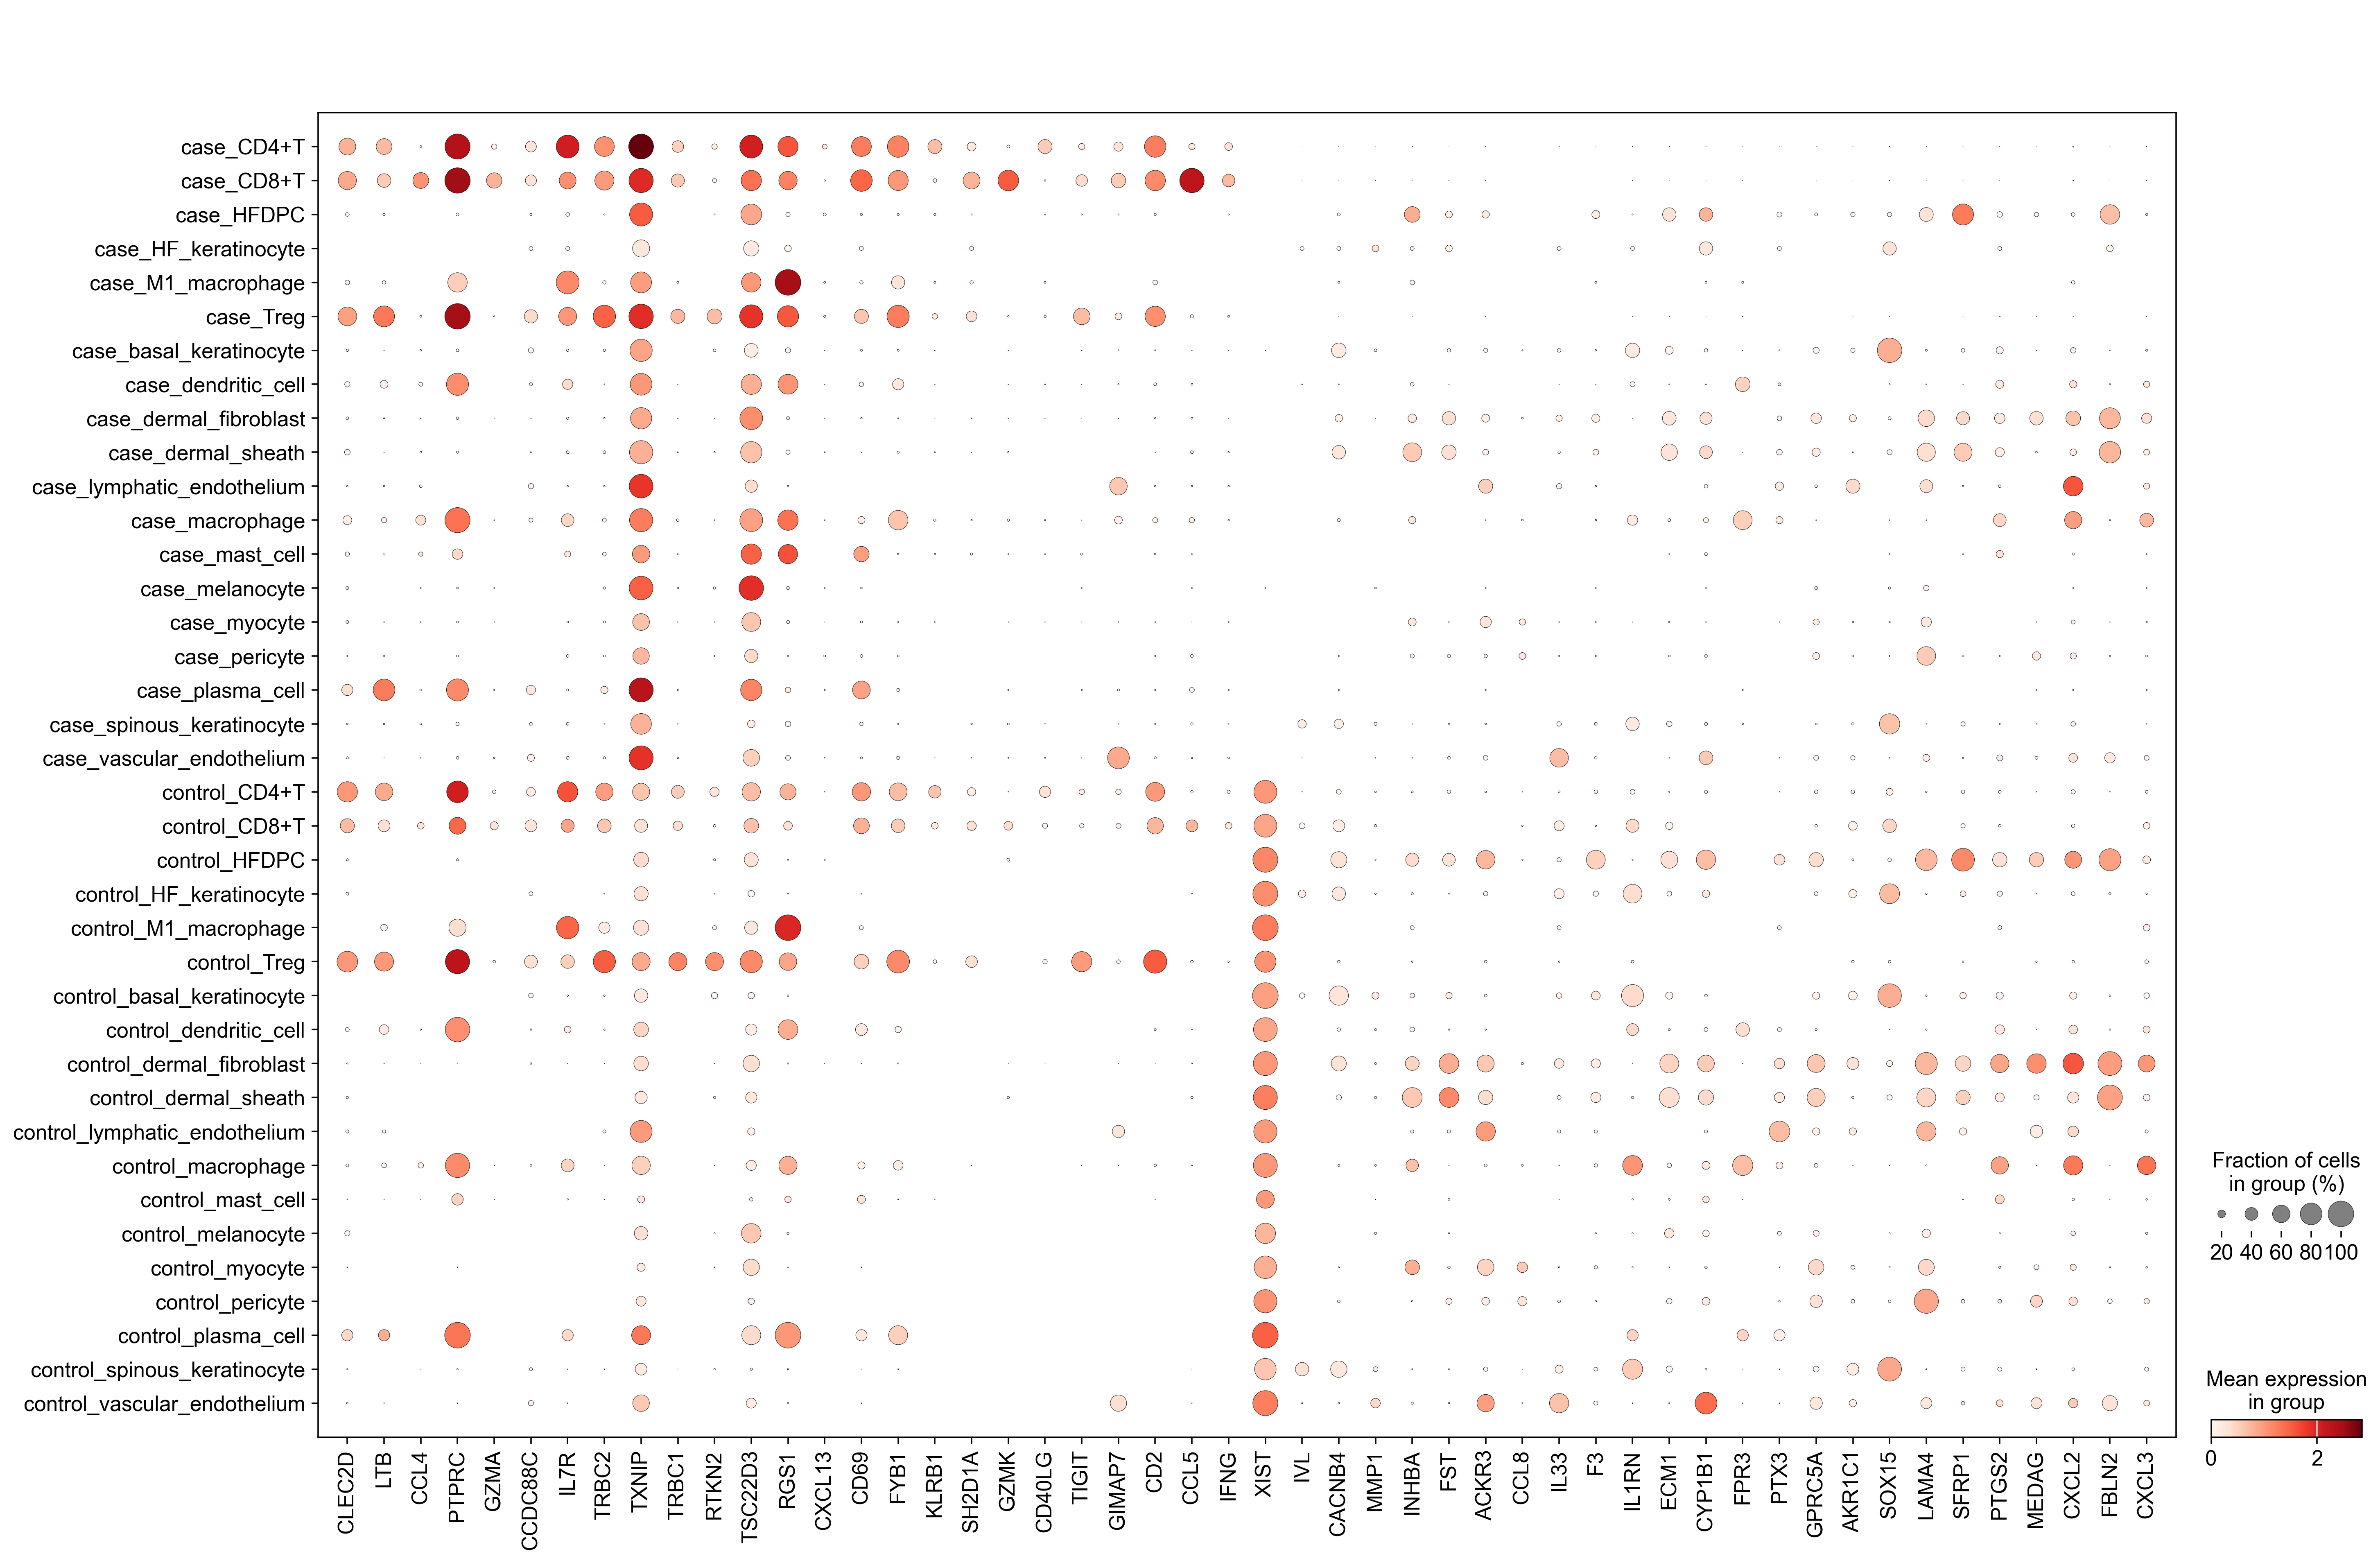

In [114]:
#plot the dotplot to observe differential expression between case vs control
sc.pl.dotplot(adata, genes_to_show, groupby=['sample', 'manual_label'])

**Comparation between T cell (CD4, CD8, Treg) of CASE and CONTROL**

In [38]:
#reload trained model
model =  scvi.model.SCVI.load('model.model', adata = adata)

INFO     File model.model/model.pt already downloaded                                                              


In [39]:
bdata = sc.read_h5ad('annotated_trained_highlyvar.h5ad')
bdata

AnnData object with n_obs × n_vars = 6699 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'sample', 'celltypist_skin_label', 'celltypist_conf_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'celltypist_skin_major', 'manual_label'
    var: 'highly_variable', 'observed_fraction_zeros', 'expected_fraction_zeros', 'prob_zero_enriched_nbatches', 'prob_zero_enrichment', 'prob_zero_enrichment_rank'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_skin_label_colors', 'celltypist_skin_major_colors', 'hvg', 'log1p', 'manual_label_colors', 'neighbors', 'overcluster', 'overcluster_colors', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'log1p_norm', 'scVI_expr'
    obsp: 'connectivities', 'distances'

In [40]:
#DE testing focus on Tcells
scvi_DE_Tcell = model.differential_expression(
    idx1 = bdata.obs['sample'].isin(['case']) & (
           (bdata.obs['manual_label'] == 'CD8+T') | 
           (bdata.obs['manual_label'] == 'CD4+T') | 
           (bdata.obs['manual_label'] == 'Treg')),
    idx2 = bdata.obs['sample'].isin(['control']) & (
           (bdata.obs['manual_label'] == 'CD8+T') | 
           (bdata.obs['manual_label'] == 'CD4+T') | 
           (bdata.obs['manual_label'] == 'Treg'))
)

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


In [41]:
scvi_DE_Tcell

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
XIST      0.9998        0.0002      8.516943  0.000034  0.001107   
RPS4Y1    0.9958        0.0042      5.468460  0.001413  0.000379   
DDX3Y     0.9924        0.0076      4.871977  0.000656  0.000132   
TXNIP     0.9894        0.0106      4.536244  0.007241  0.000901   
RERGL     0.9824        0.0176      4.022099  0.000009  0.000008   
...          ...           ...           ...       ...       ...   
SON       0.5352        0.4648      0.141033  0.000970  0.001012   
PCBP2     0.5272        0.4728      0.108908  0.000572  0.000628   
TRIR      0.5102        0.4898      0.040806  0.000669  0.000640   
ST13      0.5030        0.4970      0.012000  0.000516  0.000594   
SRRM1     0.4218        0.5782     -0.315389  0.000686  0.000713   

        pseudocounts  delta  lfc_mean  lfc_median   lfc_std    lfc_min  \
XIST             0.0   0.25 -5.369619   -5.527909  1.478117 -10.378878   
RPS4Y1           0.0   0.25  1.915216    1.885692  0.701690  -0.624282   
DDX3Y            0.0   0.25  2.333966    2.375961  0.799474  -0.930118   
TXNIP            0.0   0.25  3.013977    2.981376  1.400371  -2.809911   
RERGL            0.0   0.25  3.652893    4.594467  4.341947  -9.963737   
...              ...    ...       ...         ...       ...        ...   
SON              0.0   0.25 -0.054966   -0.077315  0.423225  -1.598481   
PCBP2            0.0   0.25 -0.134723   -0.116624  0.407885  -2.008561   
TRIR             0.0   0.25  0.078373    0.044097  0.444304  -2.158530   
ST13             0.0   0.25 -0.188241   -0.164116  0.392719  -2.390405   
SRRM1            0.0   0.25 -0.056694   -0.057962  0.309880  -1.165609   

          lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
XIST    -0.139480   0.000000   4.578948               0.000000   
RPS4Y1   5.575686   2.063420   0.000000               0.790078   
DDX3Y    5.528677   0.958474   0.000000               0.529531   
TXNIP    6.898505  14.615977   1.705263               0.947013   
RERGL   18.248928   0.013500   0.000000               0.005400   
...           ...        ...        ...                    ...   
SON      1.531317   1.487992   4.836843               0.716504   
PCBP2    1.300255   0.939236   3.315790               0.556868   
TRIR     2.400052   1.013820   2.747370               0.599730   
ST13     1.257902   0.779267   3.294739               0.471482   
SRRM1    1.045691   1.060057   3.484211               0.596018   

        non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
XIST                 0.842105              0.000000             13.032248   
RPS4Y1               0.000000             14.709938              0.000000   
DDX3Y                0.000000              6.617507              0.000000   
TXNIP                0.552632            100.535789              7.474323   
RERGL                0.000000              0.048125              0.000000   
...                       ...                   ...                   ...   
SON                  0.915789             10.834037             11.364614   
PCBP2                0.757895              6.534204              6.726285   
TRIR                 0.842105              7.298731              7.333682   
ST13                 0.747368              5.392573              6.387778   
SRRM1                0.789474              7.744095              8.043389   

        is_de_fdr_0.05  
XIST              True  
RPS4Y1            True  
DDX3Y             True  
TXNIP             True  
RERGL             True  
...                ...  
SON              False  
PCBP2            False  
TRIR             False  
ST13             False  
SRRM1            False  

[4000 rows x 19 columns]

In [42]:
#data prep for volcano plot
scvi_DE_Tcell["log10_pscore"] = np.log10(scvi_DE_Tcell["proba_not_de"])
scvi_DE_Tcell.head()

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
XIST      0.9998        0.0002      8.516943  0.000034  0.001107   
RPS4Y1    0.9958        0.0042      5.468460  0.001413  0.000379   
DDX3Y     0.9924        0.0076      4.871977  0.000656  0.000132   
TXNIP     0.9894        0.0106      4.536244  0.007241  0.000901   
RERGL     0.9824        0.0176      4.022099  0.000009  0.000008   

        pseudocounts  delta  lfc_mean  lfc_median   lfc_std    lfc_min  \
XIST             0.0   0.25 -5.369619   -5.527909  1.478117 -10.378878   
RPS4Y1           0.0   0.25  1.915216    1.885692  0.701690  -0.624282   
DDX3Y            0.0   0.25  2.333966    2.375961  0.799474  -0.930118   
TXNIP            0.0   0.25  3.013977    2.981376  1.400371  -2.809911   
RERGL            0.0   0.25  3.652893    4.594467  4.341947  -9.963737   

          lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
XIST    -0.139480   0.000000   4.578948               0.000000   
RPS4Y1   5.575686   2.063420   0.000000               0.790078   
DDX3Y    5.528677   0.958474   0.000000               0.529531   
TXNIP    6.898505  14.615977   1.705263               0.947013   
RERGL   18.248928   0.013500   0.000000               0.005400   

        non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
XIST                 0.842105              0.000000             13.032248   
RPS4Y1               0.000000             14.709938              0.000000   
DDX3Y                0.000000              6.617507              0.000000   
TXNIP                0.552632            100.535789              7.474323   
RERGL                0.000000              0.048125              0.000000   

        is_de_fdr_0.05  log10_pscore  
XIST              True     -3.698970  
RPS4Y1            True     -2.376751  
DDX3Y             True     -2.119186  
TXNIP             True     -1.974694  
RERGL             True     -1.754487

In [43]:
# Apply the function to each row in the dataframe
scvi_DE_Tcell['diff_expr'] = scvi_DE_Tcell.apply(label_gene, axis=1)

In [44]:
#get rid of of log10_pscore (p-value)
scvi_DE_Tcell_plot = scvi_DE_Tcell[scvi_DE_Tcell["log10_pscore"] != -np.inf]

In [45]:
# Filter the DataFrame based on the 'diff_expr' condition
filtered_df = scvi_DE_Tcell_plot[scvi_DE_Tcell_plot['diff_expr'] != 'NOdiff']

# Sort the filtered DataFrame by 'log10_pscore' in descending order and select the top 20
top20_df = filtered_df.nsmallest(20, 'log10_pscore')

# Create a boolean mask for the top 20 entries
mask = scvi_DE_Tcell_plot.index.isin(top20_df.index)

# Update 'delabel_top20' only for the top 20 entries
scvi_DE_Tcell_plot.loc[mask, 'delabel_top20'] = scvi_DE_Tcell_plot.index[mask]


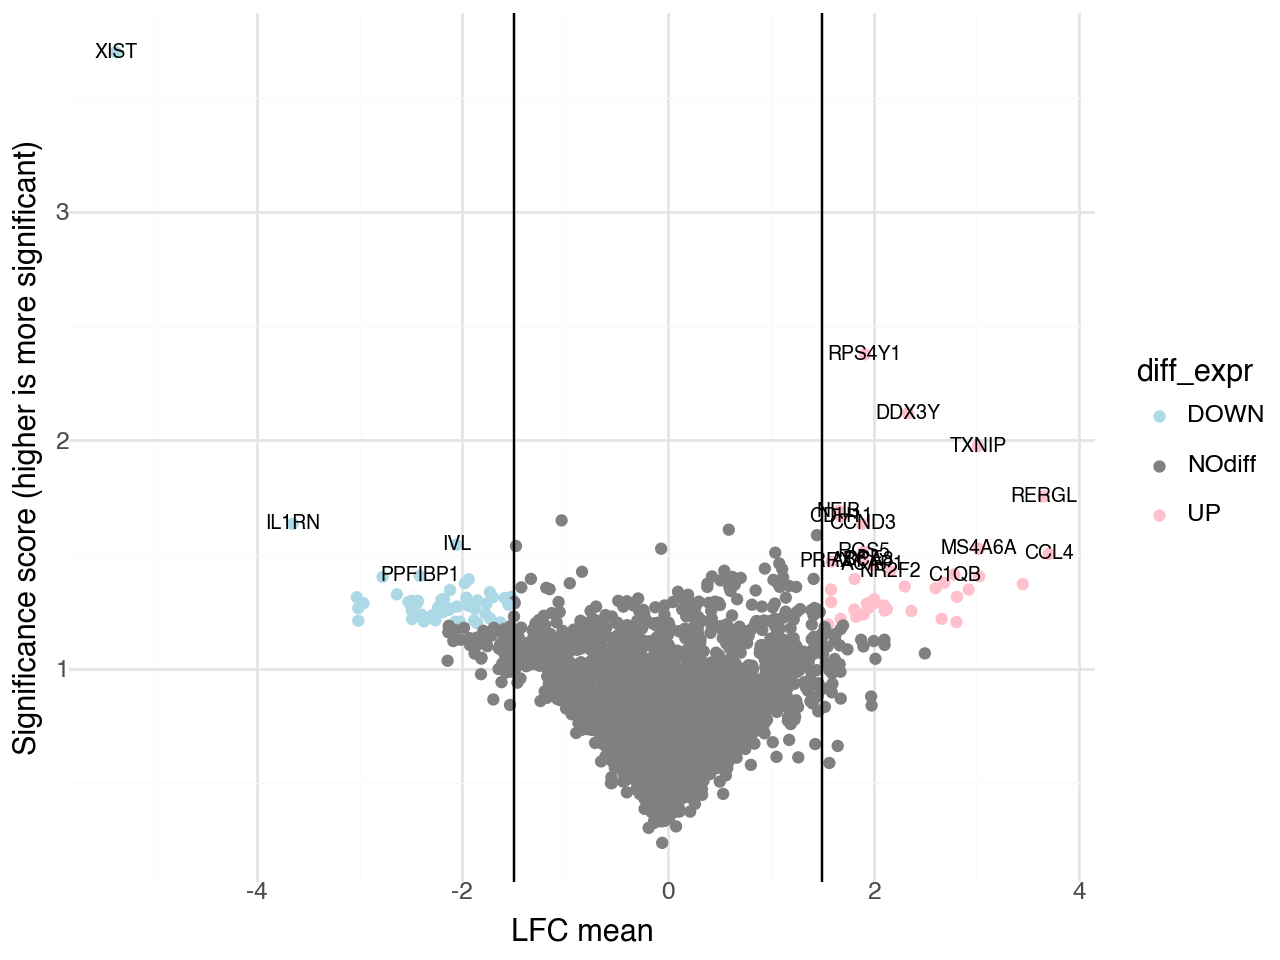

In [46]:
#use -log10 p-value
custom_colors = {"UP": "pink", "DOWN": "lightblue", "NOdiff": "gray"}
(
    p9.ggplot(scvi_DE_Tcell_plot, p9.aes("lfc_mean", "-log10_pscore", color='diff_expr', label='delabel_top20'))
    + p9.geom_point()
    + p9.geom_text(size=7, color='black')
    + p9.theme_minimal()
    + p9.scale_color_manual(values=custom_colors)
    + p9.geom_vline(xintercept = (-1.5, 1.5))
    + p9.labs(x="LFC mean", y="Significance score (higher is more significant)")
    #+ p9.geom_hline(yintercept = 0.05)
)

In [47]:
#heatmap
scvi_DE_Tcell = scvi_DE_Tcell[(scvi_DE_Tcell['is_de_fdr_0.05'] == True) & (abs(scvi_DE_Tcell['lfc_mean']) > 1.5)]
scvi_DE_Tcell = scvi_DE_case_control.sort_values('lfc_mean')
scvi_DE_Tcell

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
XIST      0.9976        0.0024      6.029880  0.000050  0.000875   
IVL       0.9806        0.0194      3.922891  0.000005  0.000077   
MMP1      0.9742        0.0258      3.631242  0.000013  0.000180   
CACNB4    0.9708        0.0292      3.503951  0.000025  0.000118   
INHBA     0.9710        0.0290      3.511030  0.000101  0.000528   
...          ...           ...           ...       ...       ...   
CD40LG    0.9700        0.0300      3.476098  0.000355  0.000042   
GIMAP7    0.9738        0.0262      3.615446  0.000386  0.000054   
CD2       0.9654        0.0346      3.328689  0.001225  0.000203   
CCL5      0.9752        0.0248      3.671799  0.001180  0.000074   
IFNG      0.9762        0.0238      3.713981  0.000481  0.000024   

        pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  \
XIST             0.0   0.25 -4.617135   -4.724290  1.607566  ...   
IVL              0.0   0.25 -4.223578   -4.286250  5.616271  ...   
MMP1             0.0   0.25 -4.167530   -4.395913  4.481683  ...   
CACNB4           0.0   0.25 -4.161415   -4.506310  4.899657  ...   
INHBA            0.0   0.25 -3.841689   -4.080461  4.695248  ...   
...              ...    ...       ...         ...       ...  ...   
CD40LG           0.0   0.25  3.892066    4.324017  3.615695  ...   
GIMAP7           0.0   0.25  4.006929    4.375257  3.072211  ...   
CD2              0.0   0.25  4.064478    4.738707  4.129558  ...   
CCL5             0.0   0.25  4.325693    4.508990  4.069562  ...   
IFNG             0.0   0.25  4.631254    4.788619  3.773030  ...   

        raw_normalized_mean2  is_de_fdr_0.05  log10_pscore  highly_variable  \
XIST               10.071143            True     -2.619789             True   
IVL                 0.608153            True     -1.712198             True   
MMP1                1.488621            True     -1.588380             True   
CACNB4              0.807226            True     -1.534617             True   
INHBA               3.560548            True     -1.537602             True   
...                      ...             ...           ...              ...   
CD40LG              0.237839            True     -1.522879             True   
GIMAP7              0.332802            True     -1.581699             True   
CD2                 1.684530            True     -1.460924             True   
CCL5                0.481730            True     -1.605548             True   
IFNG                0.130705            True     -1.623423             True   

        observed_fraction_zeros  expected_fraction_zeros  \
XIST                   0.757426                 0.387567   
IVL                    0.973280                 0.772052   
MMP1                   0.980445                 0.714499   
CACNB4                 0.891626                 0.786309   
INHBA                  0.897447                 0.508893   
...                         ...                      ...   
CD40LG                 0.863562                 0.778886   
GIMAP7                 0.819376                 0.708477   
CD2                    0.630691                 0.415116   
CCL5                   0.834602                 0.433376   
IFNG                   0.894014                 0.607381   

        prob_zero_enriched_nbatches  prob_zero_enrichment  \
XIST                              1                0.4646   
IVL                               1                0.2202   
MMP1                              1                0.2768   
CACNB4                            1                0.1876   
INHBA                             1                0.4353   
...                             ...                   ...   
CD40LG                            1                0.2017   
GIMAP7                            1                0.2431   
CD2                               1                0.3742   
CCL5                              1                0.4783   
IFNG                             

In [48]:
gene_to_show = scvi_DE_Tcell[:25].index.tolist() + scvi_DE_Tcell[-25:].index.tolist()

In [49]:
#use this adata to observe the differential expression between Tcell in case and control
subset_Tcell = bdata[(bdata.obs['manual_label'] == 'CD8+T') | 
           (bdata.obs['manual_label'] == 'CD4+T') | 
           (bdata.obs['manual_label'] == 'Treg')]
subset_Tcell.obs['manual_label'].value_counts()

manual_label
CD4+T    1929
CD8+T     793
Treg      431
Name: count, dtype: int64

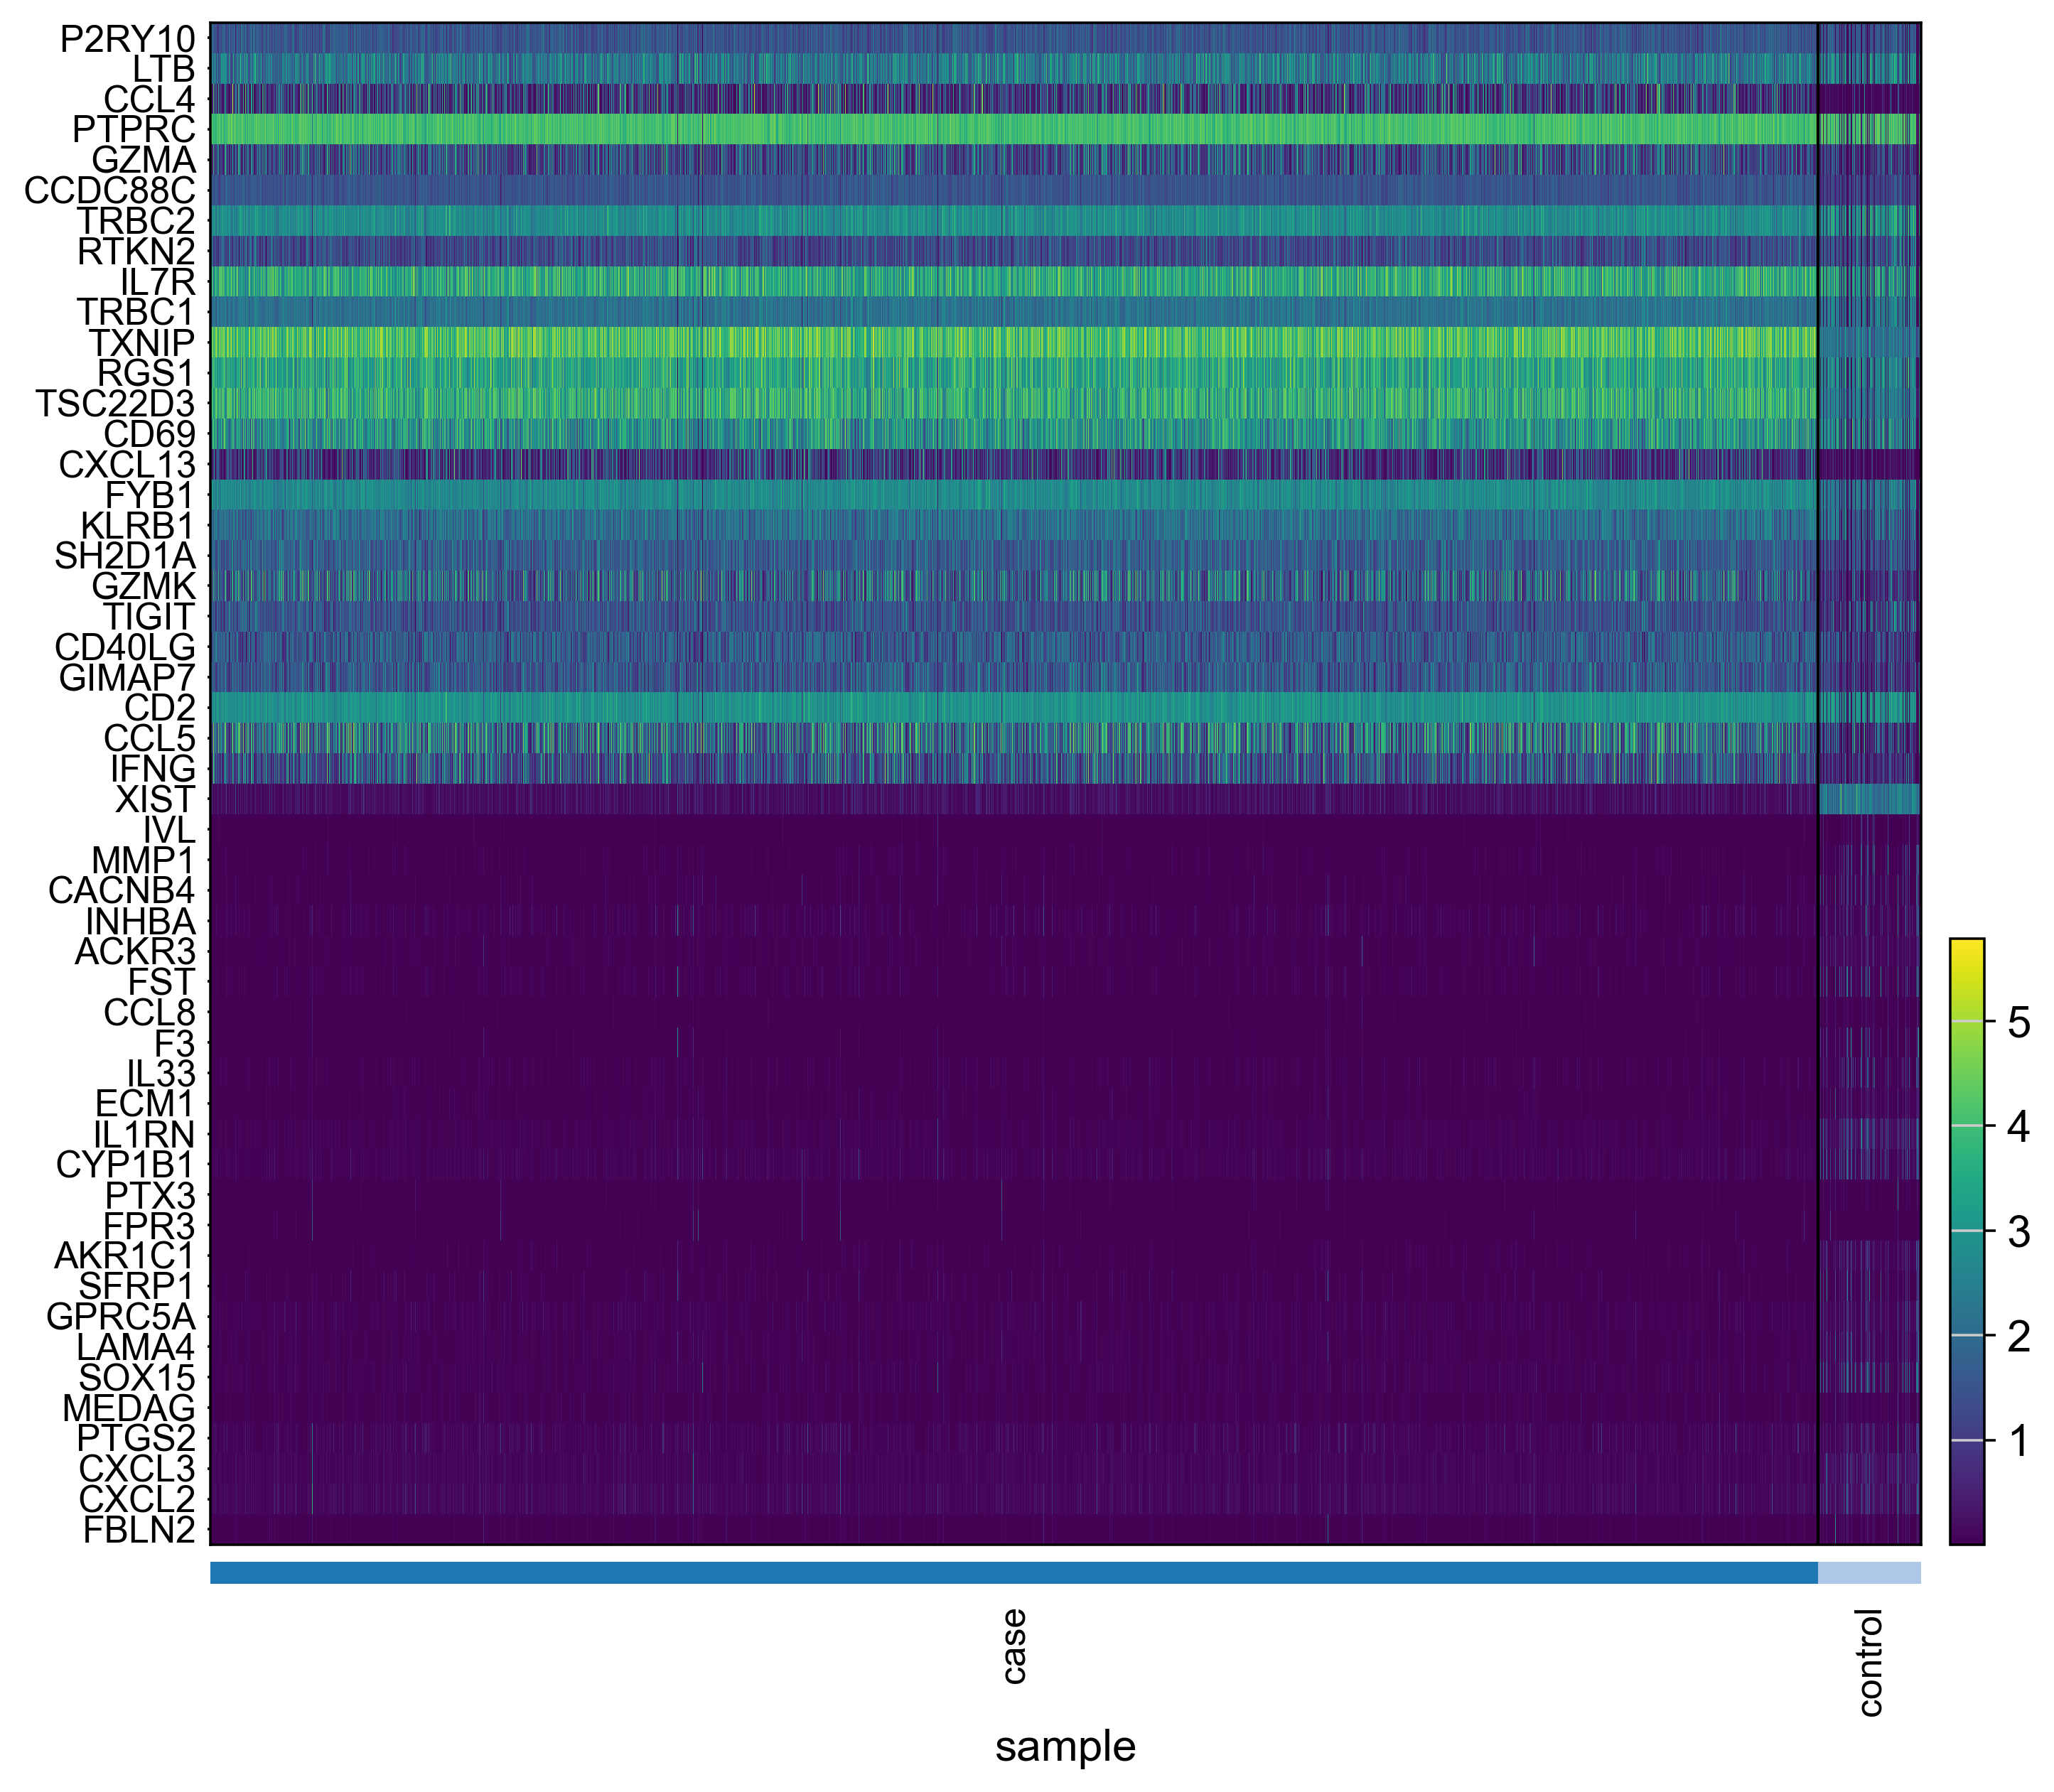

In [50]:
#plot the heat map differential expression between Tcells in  case vs control
sc.pl.heatmap(subset_Tcell, genes_to_show, groupby=['sample'], swap_axes=True, layer='scVI_expr',log=True)

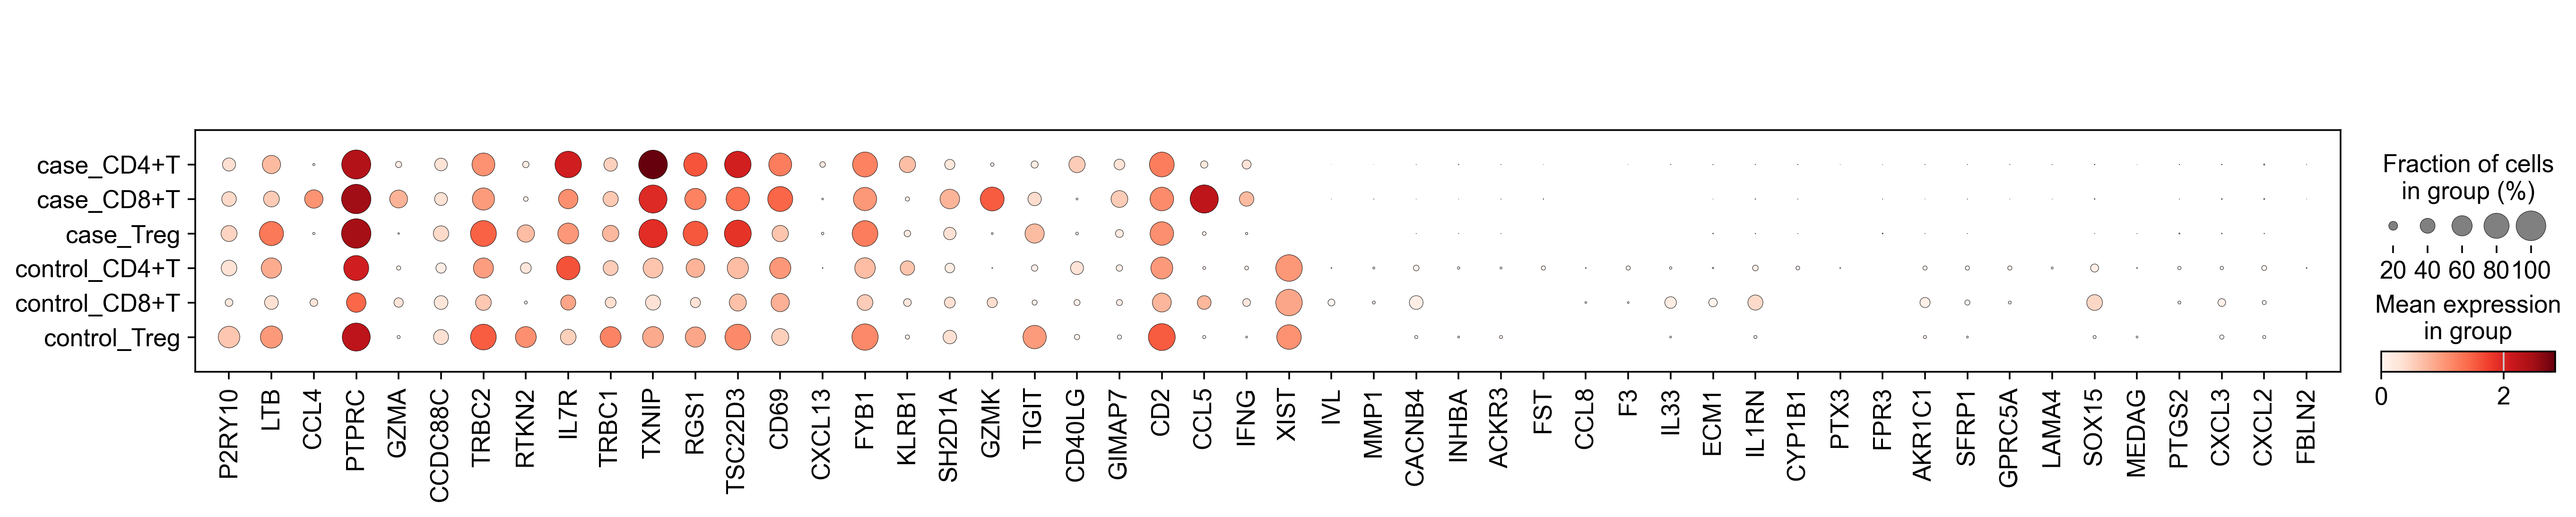

In [51]:
#plot the dotplot to observe differential expression between case vs control
sc.pl.dotplot(subset_Tcell, genes_to_show, groupby=['sample', 'manual_label'])

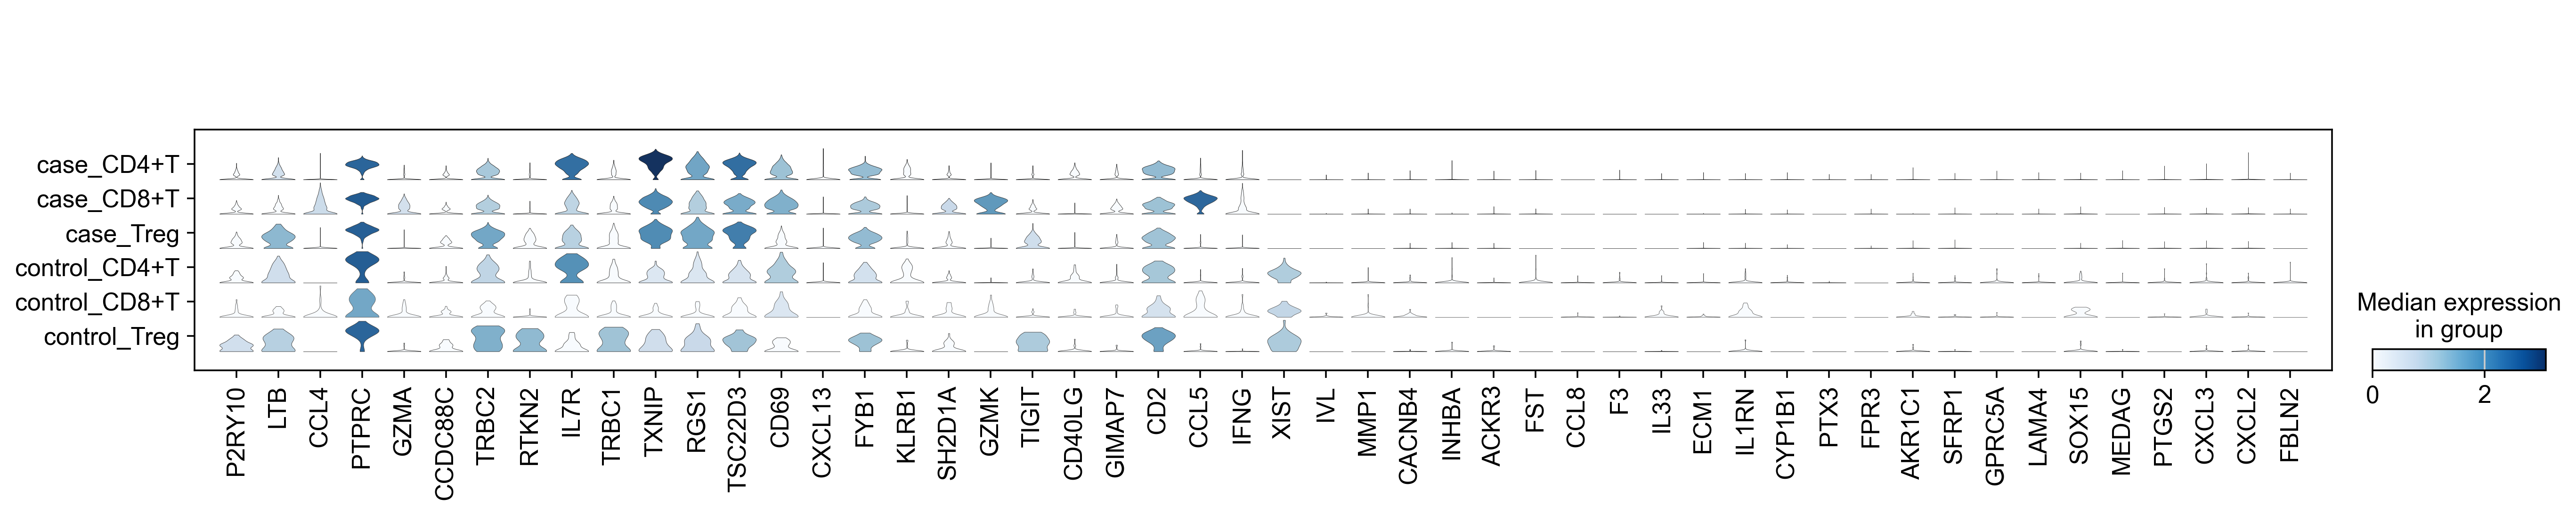

In [52]:
sc.pl.stacked_violin(subset_Tcell, genes_to_show, groupby=['sample', 'manual_label'])

## 4. Gene set enrichment and pathway analysis

In [53]:
import decoupler
import seaborn.objects as so
import random

In [7]:
import os

os.environ['R_HOME'] = '/Applications/anaconda3/envs/SCanalysis/lib/R'

In [8]:
# Setting up R dependencies

import anndata2ri
import rpy2
from rpy2.robjects import r

%load_ext rpy2.ipython

anndata2ri.activate()

/var/folders/ly/mwzzbn7j7yd69hdl9hq_23540000gn/T/ipykernel_8278/615142456.py:9: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [9]:
%%R
print("Hello from R!")

[1] "Hello from R!"


I got RecursionError: maximum recursion depth exceeded in comparison after run %%R
But it can be solved by running pip install --upgrade rpy2 notebook

In [10]:
%%R
suppressPackageStartupMessages({
    library(SingleCellExperiment)
})

#### 4.1. T cell

In [77]:
scvi_DE_Tcell_plot.head()

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
XIST      0.9998        0.0002      8.516943  0.000034  0.001107   
RPS4Y1    0.9958        0.0042      5.468460  0.001413  0.000379   
DDX3Y     0.9924        0.0076      4.871977  0.000656  0.000132   
TXNIP     0.9894        0.0106      4.536244  0.007241  0.000901   
RERGL     0.9824        0.0176      4.022099  0.000009  0.000008   

        pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
XIST             0.0   0.25 -5.369619   -5.527909  1.478117  ...   0.000000   
RPS4Y1           0.0   0.25  1.915216    1.885692  0.701690  ...   2.063420   
DDX3Y            0.0   0.25  2.333966    2.375961  0.799474  ...   0.958474   
TXNIP            0.0   0.25  3.013977    2.981376  1.400371  ...  14.615977   
RERGL            0.0   0.25  3.652893    4.594467  4.341947  ...   0.013500   

        raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
XIST     4.578948               0.000000               0.842105   
RPS4Y1   0.000000               0.790078               0.000000   
DDX3Y    0.000000               0.529531               0.000000   
TXNIP    1.705263               0.947013               0.552632   
RERGL    0.000000               0.005400               0.000000   

        raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
XIST                0.000000             13.032248            True   
RPS4Y1             14.709938              0.000000            True   
DDX3Y               6.617507              0.000000            True   
TXNIP             100.535789              7.474323            True   
RERGL               0.048125              0.000000            True   

        log10_pscore  diff_expr  delabel_top20  
XIST       -3.698970       DOWN           XIST  
RPS4Y1     -2.376751         UP         RPS4Y1  
DDX3Y      -2.119186         UP          DDX3Y  
TXNIP      -1.974694         UP          TXNIP  
RERGL      -1.754487         UP          RERGL  

[5 rows x 22 columns]

 I will sort gene rank based on the 'proba_de'. Values close to one indicate that the gene is DE.

In [76]:
scvi_DE_Tcell_plot.sort_values(by=['proba_de'], ascending=False)

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
XIST      0.9998        0.0002      8.516943  0.000034  0.001107   
RPS4Y1    0.9958        0.0042      5.468460  0.001413  0.000379   
DDX3Y     0.9924        0.0076      4.871977  0.000656  0.000132   
TXNIP     0.9894        0.0106      4.536244  0.007241  0.000901   
RERGL     0.9824        0.0176      4.022099  0.000009  0.000008   
...          ...           ...           ...       ...       ...   
SON       0.5352        0.4648      0.141033  0.000970  0.001012   
PCBP2     0.5272        0.4728      0.108908  0.000572  0.000628   
TRIR      0.5102        0.4898      0.040806  0.000669  0.000640   
ST13      0.5030        0.4970      0.012000  0.000516  0.000594   
SRRM1     0.4218        0.5782     -0.315389  0.000686  0.000713   

        pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
XIST             0.0   0.25 -5.369619   -5.527909  1.478117  ...   0.000000   
RPS4Y1           0.0   0.25  1.915216    1.885692  0.701690  ...   2.063420   
DDX3Y            0.0   0.25  2.333966    2.375961  0.799474  ...   0.958474   
TXNIP            0.0   0.25  3.013977    2.981376  1.400371  ...  14.615977   
RERGL            0.0   0.25  3.652893    4.594467  4.341947  ...   0.013500   
...              ...    ...       ...         ...       ...  ...        ...   
SON              0.0   0.25 -0.054966   -0.077315  0.423225  ...   1.487992   
PCBP2            0.0   0.25 -0.134723   -0.116624  0.407885  ...   0.939236   
TRIR             0.0   0.25  0.078373    0.044097  0.444304  ...   1.013820   
ST13             0.0   0.25 -0.188241   -0.164116  0.392719  ...   0.779267   
SRRM1            0.0   0.25 -0.056694   -0.057962  0.309880  ...   1.060057   

        raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
XIST     4.578948               0.000000               0.842105   
RPS4Y1   0.000000               0.790078               0.000000   
DDX3Y    0.000000               0.529531               0.000000   
TXNIP    1.705263               0.947013               0.552632   
RERGL    0.000000               0.005400               0.000000   
...           ...                    ...                    ...   
SON      4.836843               0.716504               0.915789   
PCBP2    3.315790               0.556868               0.757895   
TRIR     2.747370               0.599730               0.842105   
ST13     3.294739               0.471482               0.747368   
SRRM1    3.484211               0.596018               0.789474   

        raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
XIST                0.000000             13.032248            True   
RPS4Y1             14.709938              0.000000            True   
DDX3Y               6.617507              0.000000            True   
TXNIP             100.535789              7.474323            True   
RERGL               0.048125              0.000000            True   
...                      ...                   ...             ...   
SON                10.834037             11.364614           False   
PCBP2               6.534204              6.726285           False   
TRIR                7.298731              7.333682           False   
ST13                5.392573              6.387778           False   
SRRM1               7.744095              8.043389           False   

        log10_pscore  diff_expr  delabel_top20  
XIST       -3.698970       DOWN           XIST  
RPS4Y1     -2.376751         UP         RPS4Y1  
DDX3Y      -2.119186         UP          DDX3Y  
TXNIP      -1.974694         UP          TXNIP  
RERGL      -1.754487         UP          RERGL  
...              ...        ...            ...  
SON        -0.332734     NOdiff            NaN  
PCBP2      -0.325323     NOdiff            NaN  
TRIR       -0.309981     NOdiff            NaN  
ST13       -0.303644     NOdiff            NaN  
SRRM1      -0.237922     NOdiff            NaN  

[4000 r

In [78]:
DE_Tcell_rank = scvi_DE_Tcell_plot[['proba_de']]

In [79]:
DE_Tcell_rank.reset_index()

index  proba_de
0       XIST    0.9998
1     RPS4Y1    0.9958
2      DDX3Y    0.9924
3      TXNIP    0.9894
4      RERGL    0.9824
...      ...       ...
3995     SON    0.5352
3996   PCBP2    0.5272
3997    TRIR    0.5102
3998    ST13    0.5030
3999   SRRM1    0.4218

[4000 rows x 2 columns]

In [67]:
#perform GSEA enrichment tests using decoulper
# Downloading reactome pathways
from pathlib import Path

if not Path("c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !curl -o 'c2.cp.reactome.v7.5.1.symbols.gmt' -L https://figshare.com/ndownloader/files/35233771

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  751k  100  751k    0     0   235k      0  0:00:03  0:00:03 --:--:--  421k


In [68]:
def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

In [69]:
reactome = gmt_to_decoupler("c2.cp.reactome.v7.5.1.symbols.gmt")

In [70]:
reactome

geneset genesymbol
0      REACTOME_INTERLEUKIN_6_SIGNALING       JAK2
1      REACTOME_INTERLEUKIN_6_SIGNALING       TYK2
2      REACTOME_INTERLEUKIN_6_SIGNALING        CBL
3      REACTOME_INTERLEUKIN_6_SIGNALING      STAT1
4      REACTOME_INTERLEUKIN_6_SIGNALING      IL6ST
...                                 ...        ...
89471    REACTOME_ION_CHANNEL_TRANSPORT      FXYD7
89472    REACTOME_ION_CHANNEL_TRANSPORT      UBA52
89473    REACTOME_ION_CHANNEL_TRANSPORT   ATP6V1E2
89474    REACTOME_ION_CHANNEL_TRANSPORT      ASIC5
89475    REACTOME_ION_CHANNEL_TRANSPORT      FXYD1

[89476 rows x 2 columns]

In [73]:
# Filtering genesets to match behaviour of fgsea
geneset_size = reactome.groupby("geneset").size()
geneset_size

geneset
REACTOME_2_LTR_CIRCLE_FORMATION                                        7
REACTOME_ABACAVIR_METABOLISM                                           5
REACTOME_ABACAVIR_TRANSMEMBRANE_TRANSPORT                              5
REACTOME_ABACAVIR_TRANSPORT_AND_METABOLISM                            10
REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT                      103
                                                                    ... 
REACTOME_YAP1_AND_WWTR1_TAZ_STIMULATED_GENE_EXPRESSION                15
REACTOME_ZBP1_DAI_MEDIATED_INDUCTION_OF_TYPE_I_IFNS                   21
REACTOME_ZINC_EFFLUX_AND_COMPARTMENTALIZATION_BY_THE_SLC30_FAMILY      7
REACTOME_ZINC_INFLUX_INTO_CELLS_BY_THE_SLC39_GENE_FAMILY              10
REACTOME_ZINC_TRANSPORTERS                                            17
Length: 1615, dtype: int64

In [74]:
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]
gsea_genesets 

Index(['REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT',
       'REACTOME_ABC_TRANSPORTERS_IN_LIPID_HOMEOSTASIS',
       'REACTOME_ABC_TRANSPORTER_DISORDERS',
       'REACTOME_ABERRANT_REGULATION_OF_MITOTIC_EXIT_IN_CANCER_DUE_TO_RB1_DEFECTS',
       'REACTOME_ABERRANT_REGULATION_OF_MITOTIC_G1_S_TRANSITION_IN_CANCER_DUE_TO_RB1_DEFECTS',
       'REACTOME_ABORTIVE_ELONGATION_OF_HIV_1_TRANSCRIPT_IN_THE_ABSENCE_OF_TAT',
       'REACTOME_ACETYLCHOLINE_NEUROTRANSMITTER_RELEASE_CYCLE',
       'REACTOME_ACTIVATED_NOTCH1_TRANSMITS_SIGNAL_TO_THE_NUCLEUS',
       'REACTOME_ACTIVATED_PKN1_STIMULATES_TRANSCRIPTION_OF_AR_ANDROGEN_RECEPTOR_REGULATED_GENES_KLK2_AND_KLK3',
       'REACTOME_ACTIVATED_TAK1_MEDIATES_P38_MAPK_ACTIVATION',
       ...
       'REACTOME_VEGFR2_MEDIATED_VASCULAR_PERMEABILITY',
       'REACTOME_VIRAL_MESSENGER_RNA_SYNTHESIS',
       'REACTOME_VISUAL_PHOTOTRANSDUCTION',
       'REACTOME_VITAMIN_B5_PANTOTHENATE_METABOLISM',
       'REACTOME_VOLTAGE_GATED_POTASSIUM_CHANNELS',
     

In [119]:
scores, norm, pvals = decoupler.run_gsea(
    DE_Tcell_rank.T,
    reactome[reactome["geneset"].isin(gsea_genesets)],
    source="geneset",
    target="genesymbol",
)


In [120]:
gsea_results = (
    pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
    .droplevel(level=1, axis=1)
    .sort_values("pval")
)

In [121]:
gsea_results.head(10)

score      norm  pval
source                                                                      
REACTOME_TRANSPORT_TO_THE_GOLGI_AND_SUBSEQUENT_... -0.188542 -2.151598   0.0
REACTOME_TRANSPORT_OF_MATURE_TRANSCRIPT_TO_CYTO... -0.350283 -2.755055   0.0
REACTOME_TRANSLATION                               -0.256790 -3.168537   0.0
REACTOME_VIRAL_MESSENGER_RNA_SYNTHESIS             -0.403419 -2.251695   0.0
REACTOME_MITOCHONDRIAL_TRANSLATION                 -0.304432 -2.418438   0.0
REACTOME_MITOTIC_G2_G2_M_PHASES                    -0.177915 -2.013142   0.0
REACTOME_MITOTIC_METAPHASE_AND_ANAPHASE            -0.217681 -2.843529   0.0
REACTOME_MITOTIC_PROMETAPHASE                      -0.306946 -3.000645   0.0
REACTOME_TRANSCRIPTION_OF_THE_HIV_GENOME           -0.237129 -1.807489   0.0
REACTOME_MITOTIC_SPINDLE_CHECKPOINT                -0.339125 -2.502756   0.0

In [122]:
gsea_results['-log10_pval'] = gsea_results['pval'].map(lambda x: -np.log10(x))

In [123]:
gsea_results.head(20)

score      norm  pval  \
source                                                                         
REACTOME_TRANSPORT_TO_THE_GOLGI_AND_SUBSEQUENT_... -0.188542 -2.151598   0.0   
REACTOME_TRANSPORT_OF_MATURE_TRANSCRIPT_TO_CYTO... -0.350283 -2.755055   0.0   
REACTOME_TRANSLATION                               -0.256790 -3.168537   0.0   
REACTOME_VIRAL_MESSENGER_RNA_SYNTHESIS             -0.403419 -2.251695   0.0   
REACTOME_MITOCHONDRIAL_TRANSLATION                 -0.304432 -2.418438   0.0   
REACTOME_MITOTIC_G2_G2_M_PHASES                    -0.177915 -2.013142   0.0   
REACTOME_MITOTIC_METAPHASE_AND_ANAPHASE            -0.217681 -2.843529   0.0   
REACTOME_MITOTIC_PROMETAPHASE                      -0.306946 -3.000645   0.0   
REACTOME_TRANSCRIPTION_OF_THE_HIV_GENOME           -0.237129 -1.807489   0.0   
REACTOME_MITOTIC_SPINDLE_CHECKPOINT                -0.339125 -2.502756   0.0   
REACTOME_MOLECULES_ASSOCIATED_WITH_ELASTIC_FIBRES   0.525444  2.507562   0.0   
REACTOME_MRNA_SPLICING                             -0.314294 -4.350777   0.0   
REACTOME_MRNA_SPLICING_MINOR_PATHWAY               -0.359382 -2.809039   0.0   
REACTOME_TRANSCRIPTIONAL_REGULATION_BY_TP53        -0.143768 -2.310630   0.0   
REACTOME_TRANSCRIPTIONAL_REGULATION_BY_SMALL_RNAS  -0.384926 -2.208145   0.0   
REACTOME_INTEGRIN_CELL_SURFACE_INTERACTIONS         0.527465  3.311507   0.0   
REACTOME_INTERACTIONS_OF_REV_WITH_HOST_CELLULAR... -0.510281 -2.333735   0.0   
REACTOME_ANTIMICROBIAL_PEPTIDES                     0.631988  2.473332   0.0   
REACTOME_ANTIGEN_PROCESSING_UBIQUITINATION_PROT... -0.151495 -2.194100   0.0   
REACTOME_INTERLEUKIN_10_SIGNALING                   0.594202  3.347407   0.0   

                                                    -log10_pval  
source                                                           
REACTOME_TRANSPORT_TO_THE_GOLGI_AND_SUBSEQUENT_...          inf  
REACTOME_TRANSPORT_OF_MATURE_TRANSCRIPT_TO_CYTO...          inf  
REACTOME_TRANSLATION                                        inf  
REACTOME_VIRAL_MESSENGER_RNA_SYNTHESIS                      inf  
REACTOME_MITOCHONDRIAL_TRANSLATION                          inf  
REACTOME_MITOTIC_G2_G2_M_PHASES                             inf  
REACTOME_MITOTIC_METAPHASE_AND_ANAPHASE                     inf  
REACTOME_MITOTIC_PROMETAPHASE                               inf  
REACTOME_TRANSCRIPTION_OF_THE_HIV_GENOME                    inf  
REACTOME_MITOTIC_SPINDLE_CHECKPOINT                         inf  
REACTOME_MOLECULES_ASSOCIATED_WITH_ELASTIC_FIBRES           inf  
REACTOME_MRNA_SPLICING                                      inf  
REACTOME_MRNA_SPLICING_MINOR_PATHWAY                        inf  
REACTOME_TRANSCRIPTIONAL_REGULATION_BY_TP53                 inf  
REACTOME_TRANSCRIPTIONAL_REGULATION_BY_SMALL_RNAS           inf  
REACTOME_INTEGRIN_CELL_SURFACE_INTERACTIONS                 inf  
REACTOME_INTERACTIONS_OF_REV_WITH_HOST_CELLULAR...          inf  
REACTOME_ANTIMICROBIAL_PEPTIDES                             inf  
REACTOME_ANTIGEN_PROCESSING_UBIQUITINATION_PROT...          inf  
REACTOME_INTERLEUKIN_10_SIGNALING                           inf

In [133]:
# Filter out rows where log_pvalue is inf
gsea_results = gsea_results[gsea_results["-log10_pval"] != np.inf]

<Axes: xlabel='-log10_pval', ylabel='source'>

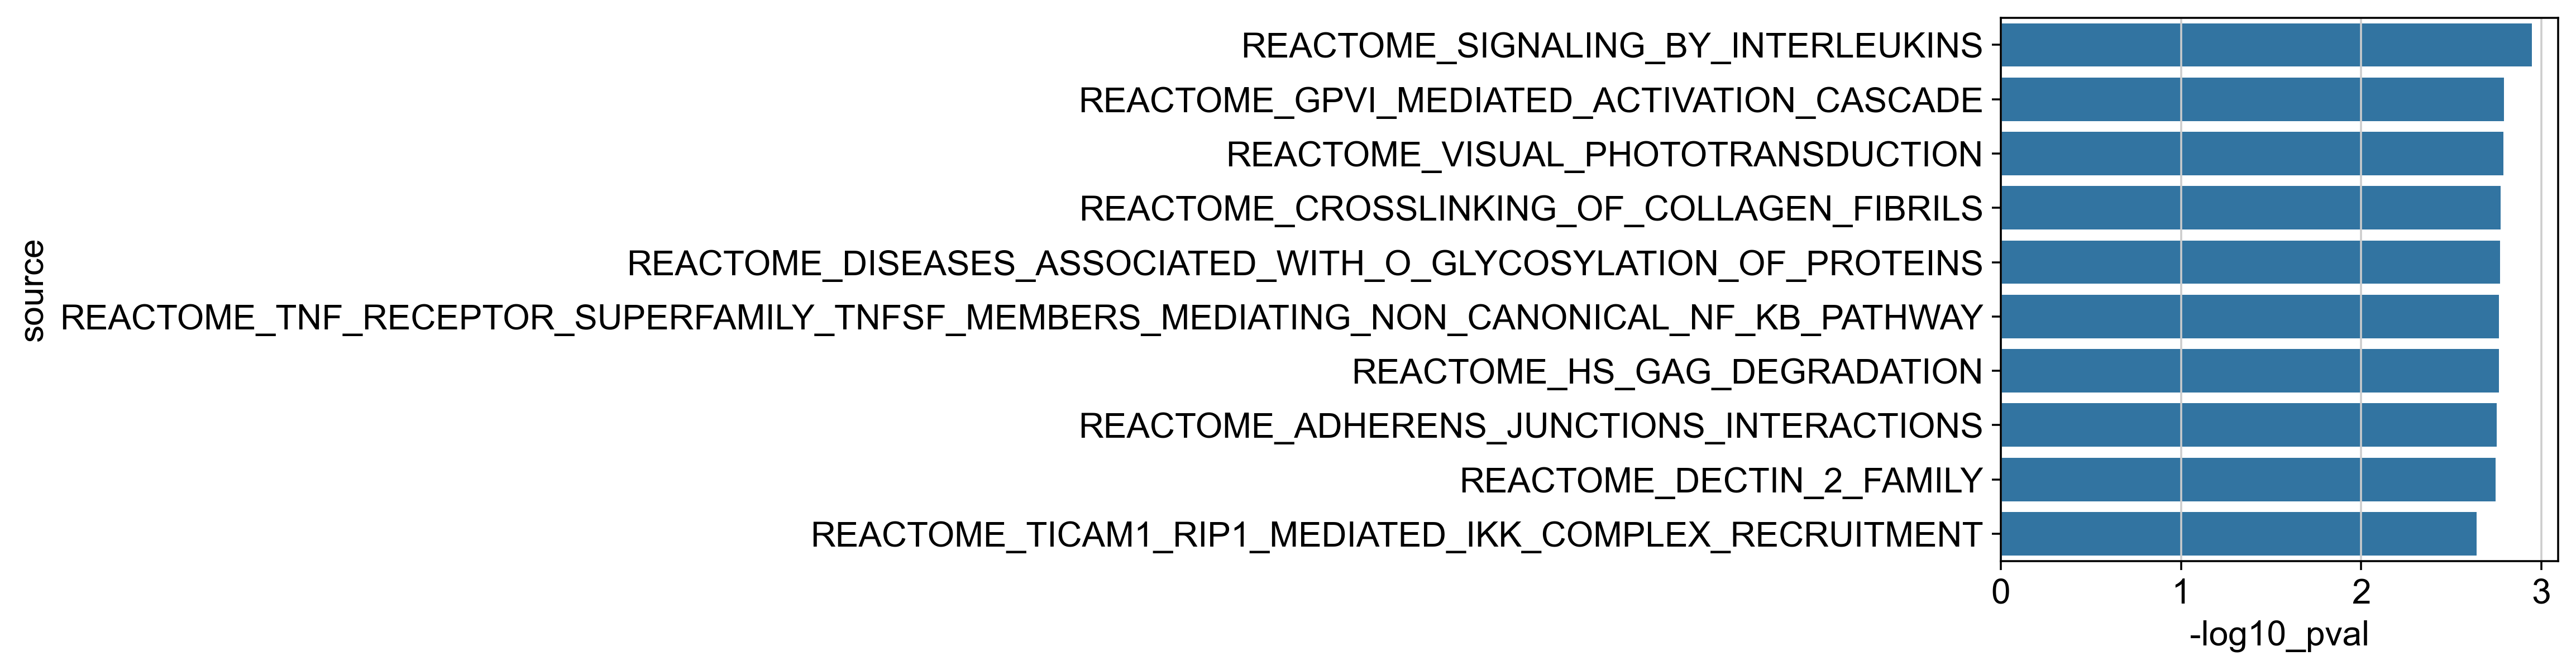

In [139]:
sns.barplot(data=gsea_results.iloc[0:10], x='-log10_pval', y=gsea_results.index[0:10])